# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 20 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.random.uniform(low = 0.2e-7, high = 5e-7, size = (5, ))
regularization_strengths = np.random.uniform(low = 1e4, high = 5e4, size = (5, ))

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        svm2 = LinearSVM()
        svm2.train(X_train_feats, y_train, learning_rates[i], regularization_strengths[j], 1500, 200, True)
        train_pred = svm2.predict(X_train_feats)
        train_acc = np.mean(y_train == train_pred)
        val_pred = svm2.predict(X_val_feats)
        val_acc = np.mean(y_val == val_pred)
        results[(learning_rates[i], regularization_strengths[j])] = (train_acc, val_acc)
        if(val_acc > best_val):
            best_val = val_acc
            best_svm = svm2
pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 64.696397
iteration 100 / 1500: loss 11.444402
iteration 200 / 1500: loss 9.107019
iteration 300 / 1500: loss 9.004200
iteration 400 / 1500: loss 8.999638
iteration 500 / 1500: loss 8.999326
iteration 600 / 1500: loss 8.999594
iteration 700 / 1500: loss 8.999521
iteration 800 / 1500: loss 8.999493
iteration 900 / 1500: loss 8.999460
iteration 1000 / 1500: loss 8.999460
iteration 1100 / 1500: loss 8.999428
iteration 1200 / 1500: loss 8.999558
iteration 1300 / 1500: loss 8.999405
iteration 1400 / 1500: loss 8.999423
iteration 0 / 1500: loss 52.525024
iteration 100 / 1500: loss 13.132514
iteration 200 / 1500: loss 9.392574
iteration 300 / 1500: loss 9.036626
iteration 400 / 1500: loss 9.002581
iteration 500 / 1500: loss 8.999644
iteration 600 / 1500: loss 8.999265
iteration 700 / 1500: loss 8.999401
iteration 800 / 1500: loss 8.999256
iteration 900 / 1500: loss 8.999290
iteration 1000 / 1500: loss 8.999166
iteration 1100 / 1500: loss 8.999393
iteration 1200 / 1500

iteration 100 / 1500: loss 18.400219
iteration 200 / 1500: loss 10.633478
iteration 300 / 1500: loss 9.283888
iteration 400 / 1500: loss 9.048845
iteration 500 / 1500: loss 9.008033
iteration 600 / 1500: loss 9.001016
iteration 700 / 1500: loss 8.999657
iteration 800 / 1500: loss 8.999449
iteration 900 / 1500: loss 8.999472
iteration 1000 / 1500: loss 8.999482
iteration 1100 / 1500: loss 8.999454
iteration 1200 / 1500: loss 8.999573
iteration 1300 / 1500: loss 8.999424
iteration 1400 / 1500: loss 8.999467
iteration 0 / 1500: loss 52.506267
iteration 100 / 1500: loss 20.650987
iteration 200 / 1500: loss 12.121772
iteration 300 / 1500: loss 9.834767
iteration 400 / 1500: loss 9.222667
iteration 500 / 1500: loss 9.059286
iteration 600 / 1500: loss 9.015324
iteration 700 / 1500: loss 9.003308
iteration 800 / 1500: loss 9.000431
iteration 900 / 1500: loss 8.999605
iteration 1000 / 1500: loss 8.999356
iteration 1100 / 1500: loss 8.999212
iteration 1200 / 1500: loss 8.999226
iteration 1300 / 

In [17]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


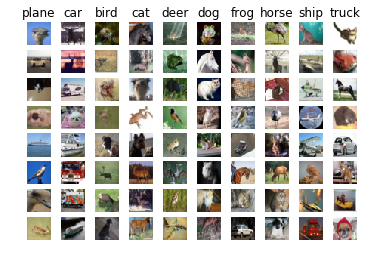

In [18]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [5]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 165)
(49000, 164)


iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.871727
iteration 200 / 1500: loss 1.550304
iteration 300 / 1500: loss 1.514562
iteration 400 / 1500: loss 1.538307
iteration 500 / 1500: loss 1.490812
iteration 600 / 1500: loss 1.492953
iteration 700 / 1500: loss 1.448671
iteration 800 / 1500: loss 1.577063
iteration 900 / 1500: loss 1.540790
iteration 1000 / 1500: loss 1.602766
iteration 1100 / 1500: loss 1.530840
iteration 1200 / 1500: loss 1.598770
iteration 1300 / 1500: loss 1.534209
iteration 1400 / 1500: loss 1.516326


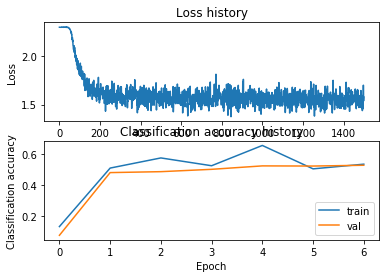

0.528
0.535
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.927527
iteration 200 / 1500: loss 1.727580
iteration 300 / 1500: loss 1.481653
iteration 400 / 1500: loss 1.539966
iteration 500 / 1500: loss 1.622948
iteration 600 / 1500: loss 1.519003
iteration 700 / 1500: loss 1.563100
iteration 800 / 1500: loss 1.514139
iteration 900 / 1500: loss 1.521168
iteration 1000 / 1500: loss 1.407745
iteration 1100 / 1500: loss 1.467693
iteration 1200 / 1500: loss 1.519158
iteration 1300 / 1500: loss 1.614908
iteration 1400 / 1500: loss 1.384844


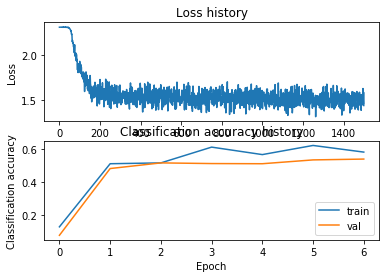

0.538
0.58
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.892960
iteration 200 / 1500: loss 1.531139
iteration 300 / 1500: loss 1.660269
iteration 400 / 1500: loss 1.614581
iteration 500 / 1500: loss 1.525518
iteration 600 / 1500: loss 1.484888
iteration 700 / 1500: loss 1.585528
iteration 800 / 1500: loss 1.523315
iteration 900 / 1500: loss 1.432706
iteration 1000 / 1500: loss 1.480841
iteration 1100 / 1500: loss 1.510451
iteration 1200 / 1500: loss 1.491410
iteration 1300 / 1500: loss 1.493845
iteration 1400 / 1500: loss 1.533371


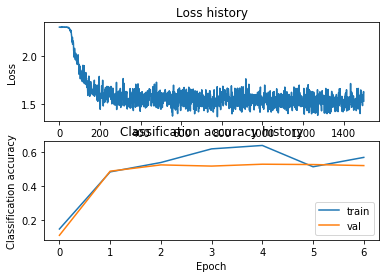

0.522
0.57
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.831373
iteration 200 / 1500: loss 1.611682
iteration 300 / 1500: loss 1.534527
iteration 400 / 1500: loss 1.600169
iteration 500 / 1500: loss 1.528234
iteration 600 / 1500: loss 1.519331
iteration 700 / 1500: loss 1.538137
iteration 800 / 1500: loss 1.560934
iteration 900 / 1500: loss 1.669524
iteration 1000 / 1500: loss 1.437824
iteration 1100 / 1500: loss 1.574181
iteration 1200 / 1500: loss 1.502842
iteration 1300 / 1500: loss 1.594693
iteration 1400 / 1500: loss 1.572987


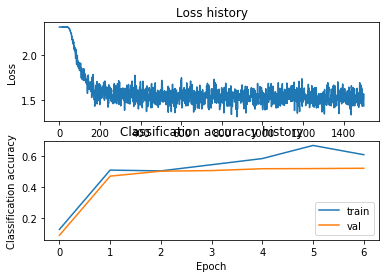

0.522
0.61
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.847454
iteration 200 / 1500: loss 1.524175
iteration 300 / 1500: loss 1.485387
iteration 400 / 1500: loss 1.614452
iteration 500 / 1500: loss 1.545447
iteration 600 / 1500: loss 1.551394
iteration 700 / 1500: loss 1.486990
iteration 800 / 1500: loss 1.461916
iteration 900 / 1500: loss 1.568962
iteration 1000 / 1500: loss 1.417909
iteration 1100 / 1500: loss 1.470922
iteration 1200 / 1500: loss 1.419654
iteration 1300 / 1500: loss 1.486627
iteration 1400 / 1500: loss 1.508316


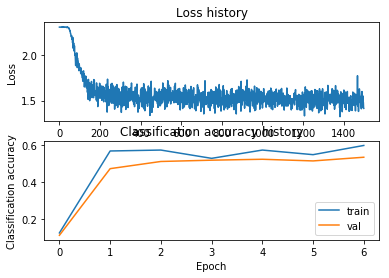

0.536
0.6
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.812309
iteration 200 / 1500: loss 1.511060
iteration 300 / 1500: loss 1.545684
iteration 400 / 1500: loss 1.568997
iteration 500 / 1500: loss 1.489550
iteration 600 / 1500: loss 1.570332
iteration 700 / 1500: loss 1.550110
iteration 800 / 1500: loss 1.533287
iteration 900 / 1500: loss 1.472974
iteration 1000 / 1500: loss 1.494858
iteration 1100 / 1500: loss 1.504659
iteration 1200 / 1500: loss 1.556203
iteration 1300 / 1500: loss 1.438995
iteration 1400 / 1500: loss 1.459847


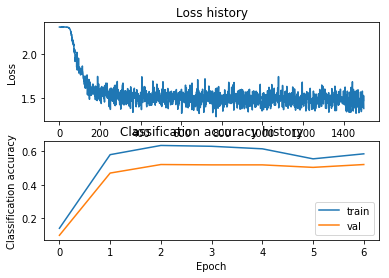

0.521
0.585
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.854176
iteration 200 / 1500: loss 1.597525
iteration 300 / 1500: loss 1.519227
iteration 400 / 1500: loss 1.546309
iteration 500 / 1500: loss 1.615861
iteration 600 / 1500: loss 1.612658
iteration 700 / 1500: loss 1.585143
iteration 800 / 1500: loss 1.537976
iteration 900 / 1500: loss 1.579470
iteration 1000 / 1500: loss 1.516028
iteration 1100 / 1500: loss 1.560958
iteration 1200 / 1500: loss 1.493967
iteration 1300 / 1500: loss 1.531166
iteration 1400 / 1500: loss 1.540724


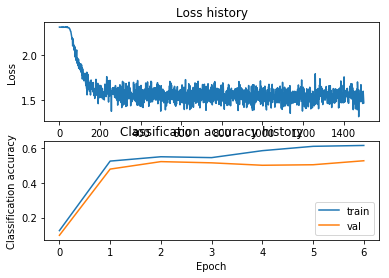

0.527
0.615
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.853530
iteration 200 / 1500: loss 1.488373
iteration 300 / 1500: loss 1.481987
iteration 400 / 1500: loss 1.447081
iteration 500 / 1500: loss 1.619353
iteration 600 / 1500: loss 1.534869
iteration 700 / 1500: loss 1.487438
iteration 800 / 1500: loss 1.406147
iteration 900 / 1500: loss 1.491396
iteration 1000 / 1500: loss 1.405896
iteration 1100 / 1500: loss 1.355009
iteration 1200 / 1500: loss 1.442634
iteration 1300 / 1500: loss 1.325713
iteration 1400 / 1500: loss 1.464583


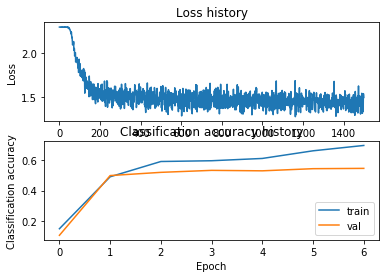

0.545
0.695
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.930374
iteration 200 / 1500: loss 1.572207
iteration 300 / 1500: loss 1.579765
iteration 400 / 1500: loss 1.424794
iteration 500 / 1500: loss 1.476208
iteration 600 / 1500: loss 1.555715
iteration 700 / 1500: loss 1.488624
iteration 800 / 1500: loss 1.467393
iteration 900 / 1500: loss 1.325491
iteration 1000 / 1500: loss 1.470386
iteration 1100 / 1500: loss 1.341569
iteration 1200 / 1500: loss 1.413247
iteration 1300 / 1500: loss 1.338577
iteration 1400 / 1500: loss 1.434231


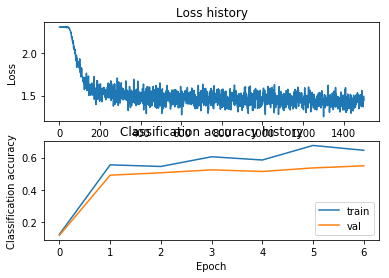

0.549
0.645
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.820529
iteration 200 / 1500: loss 1.597323
iteration 300 / 1500: loss 1.575015
iteration 400 / 1500: loss 1.460429
iteration 500 / 1500: loss 1.608315
iteration 600 / 1500: loss 1.577686
iteration 700 / 1500: loss 1.551514
iteration 800 / 1500: loss 1.569490
iteration 900 / 1500: loss 1.521740
iteration 1000 / 1500: loss 1.495068
iteration 1100 / 1500: loss 1.507710
iteration 1200 / 1500: loss 1.506911
iteration 1300 / 1500: loss 1.511223
iteration 1400 / 1500: loss 1.627517


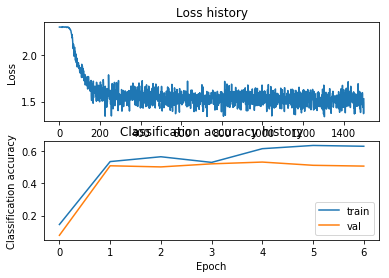

0.507
0.63
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.850466
iteration 200 / 1500: loss 1.542434
iteration 300 / 1500: loss 1.584289
iteration 400 / 1500: loss 1.616919
iteration 500 / 1500: loss 1.478575
iteration 600 / 1500: loss 1.599443
iteration 700 / 1500: loss 1.559955
iteration 800 / 1500: loss 1.509093
iteration 900 / 1500: loss 1.624138
iteration 1000 / 1500: loss 1.665923
iteration 1100 / 1500: loss 1.564797
iteration 1200 / 1500: loss 1.519868
iteration 1300 / 1500: loss 1.452646
iteration 1400 / 1500: loss 1.576764


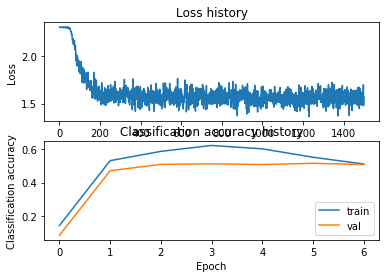

0.507
0.51
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.840340
iteration 200 / 1500: loss 1.597572
iteration 300 / 1500: loss 1.482619
iteration 400 / 1500: loss 1.571325
iteration 500 / 1500: loss 1.535225
iteration 600 / 1500: loss 1.508272
iteration 700 / 1500: loss 1.484584
iteration 800 / 1500: loss 1.563923
iteration 900 / 1500: loss 1.473300
iteration 1000 / 1500: loss 1.462280
iteration 1100 / 1500: loss 1.588814
iteration 1200 / 1500: loss 1.583482
iteration 1300 / 1500: loss 1.457332
iteration 1400 / 1500: loss 1.496207


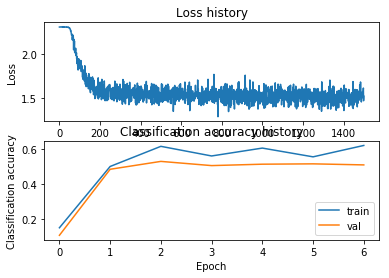

0.509
0.62
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.862924
iteration 200 / 1500: loss 1.531175
iteration 300 / 1500: loss 1.533918
iteration 400 / 1500: loss 1.425741
iteration 500 / 1500: loss 1.635793
iteration 600 / 1500: loss 1.446783
iteration 700 / 1500: loss 1.574374
iteration 800 / 1500: loss 1.427371
iteration 900 / 1500: loss 1.622013
iteration 1000 / 1500: loss 1.442825
iteration 1100 / 1500: loss 1.487969
iteration 1200 / 1500: loss 1.535461
iteration 1300 / 1500: loss 1.565234
iteration 1400 / 1500: loss 1.623161


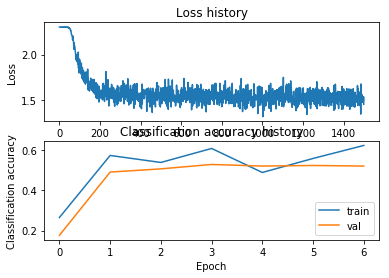

0.522
0.625
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.801093
iteration 200 / 1500: loss 1.557570
iteration 300 / 1500: loss 1.519138
iteration 400 / 1500: loss 1.482251
iteration 500 / 1500: loss 1.461138
iteration 600 / 1500: loss 1.450433
iteration 700 / 1500: loss 1.544825
iteration 800 / 1500: loss 1.435474
iteration 900 / 1500: loss 1.467736
iteration 1000 / 1500: loss 1.552451
iteration 1100 / 1500: loss 1.590967
iteration 1200 / 1500: loss 1.474046
iteration 1300 / 1500: loss 1.453595
iteration 1400 / 1500: loss 1.450122


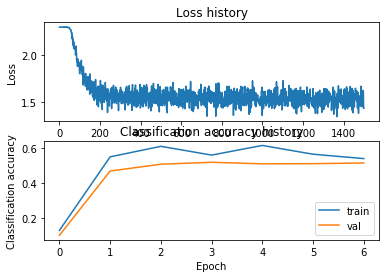

0.515
0.54
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.873326
iteration 200 / 1500: loss 1.435275
iteration 300 / 1500: loss 1.468687
iteration 400 / 1500: loss 1.566206
iteration 500 / 1500: loss 1.622965
iteration 600 / 1500: loss 1.539584
iteration 700 / 1500: loss 1.454383
iteration 800 / 1500: loss 1.426719
iteration 900 / 1500: loss 1.565111
iteration 1000 / 1500: loss 1.572377
iteration 1100 / 1500: loss 1.396793
iteration 1200 / 1500: loss 1.407181
iteration 1300 / 1500: loss 1.398260
iteration 1400 / 1500: loss 1.496017


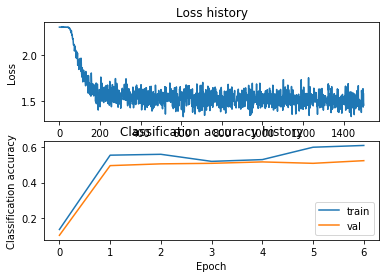

0.524
0.61
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.916066
iteration 200 / 1500: loss 1.539407
iteration 300 / 1500: loss 1.731550
iteration 400 / 1500: loss 1.506813
iteration 500 / 1500: loss 1.679712
iteration 600 / 1500: loss 1.478834
iteration 700 / 1500: loss 1.422769
iteration 800 / 1500: loss 1.547655
iteration 900 / 1500: loss 1.460203
iteration 1000 / 1500: loss 1.320854
iteration 1100 / 1500: loss 1.476043
iteration 1200 / 1500: loss 1.468665
iteration 1300 / 1500: loss 1.599216
iteration 1400 / 1500: loss 1.442808


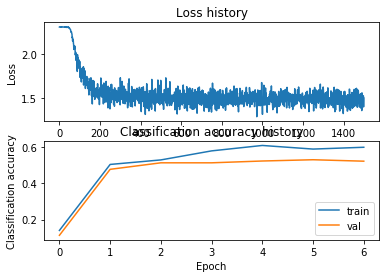

0.523
0.6
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.823324
iteration 200 / 1500: loss 1.676769
iteration 300 / 1500: loss 1.636326
iteration 400 / 1500: loss 1.634762
iteration 500 / 1500: loss 1.460554
iteration 600 / 1500: loss 1.483935
iteration 700 / 1500: loss 1.480932
iteration 800 / 1500: loss 1.534908
iteration 900 / 1500: loss 1.485966
iteration 1000 / 1500: loss 1.641396
iteration 1100 / 1500: loss 1.551725
iteration 1200 / 1500: loss 1.660293
iteration 1300 / 1500: loss 1.565729
iteration 1400 / 1500: loss 1.632758


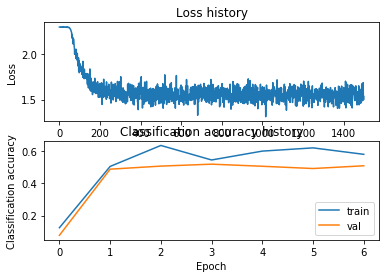

0.509
0.58
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.869860
iteration 200 / 1500: loss 1.675411
iteration 300 / 1500: loss 1.551472
iteration 400 / 1500: loss 1.408308
iteration 500 / 1500: loss 1.469961
iteration 600 / 1500: loss 1.511388
iteration 700 / 1500: loss 1.461033
iteration 800 / 1500: loss 1.511355
iteration 900 / 1500: loss 1.316080
iteration 1000 / 1500: loss 1.454631
iteration 1100 / 1500: loss 1.448105
iteration 1200 / 1500: loss 1.522230
iteration 1300 / 1500: loss 1.480127
iteration 1400 / 1500: loss 1.389012


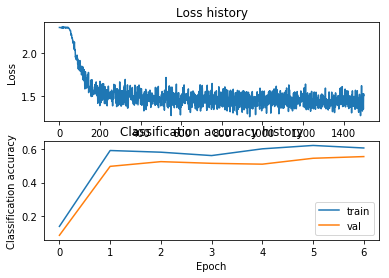

0.554
0.605
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.801262
iteration 200 / 1500: loss 1.489868
iteration 300 / 1500: loss 1.411540
iteration 400 / 1500: loss 1.497749
iteration 500 / 1500: loss 1.417495
iteration 600 / 1500: loss 1.459543
iteration 700 / 1500: loss 1.592200
iteration 800 / 1500: loss 1.498520
iteration 900 / 1500: loss 1.411907
iteration 1000 / 1500: loss 1.375380
iteration 1100 / 1500: loss 1.333628
iteration 1200 / 1500: loss 1.382340
iteration 1300 / 1500: loss 1.461257
iteration 1400 / 1500: loss 1.350984


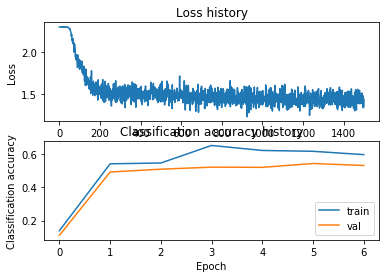

0.53
0.595
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.860832
iteration 200 / 1500: loss 1.548075
iteration 300 / 1500: loss 1.567727
iteration 400 / 1500: loss 1.557193
iteration 500 / 1500: loss 1.490591
iteration 600 / 1500: loss 1.545800
iteration 700 / 1500: loss 1.564775
iteration 800 / 1500: loss 1.554145
iteration 900 / 1500: loss 1.521345
iteration 1000 / 1500: loss 1.667934
iteration 1100 / 1500: loss 1.473450
iteration 1200 / 1500: loss 1.538660
iteration 1300 / 1500: loss 1.550225
iteration 1400 / 1500: loss 1.532892


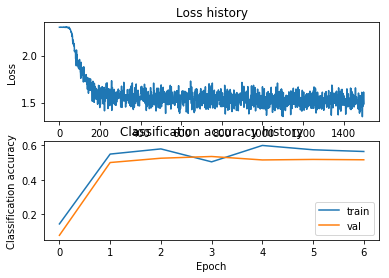

0.517
0.565
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 2.299011
iteration 200 / 1500: loss 2.047939
iteration 300 / 1500: loss 1.762606
iteration 400 / 1500: loss 1.622978
iteration 500 / 1500: loss 1.633993
iteration 600 / 1500: loss 1.503892
iteration 700 / 1500: loss 1.593491
iteration 800 / 1500: loss 1.537852
iteration 900 / 1500: loss 1.560122
iteration 1000 / 1500: loss 1.555059
iteration 1100 / 1500: loss 1.517032
iteration 1200 / 1500: loss 1.479086
iteration 1300 / 1500: loss 1.638423
iteration 1400 / 1500: loss 1.502572


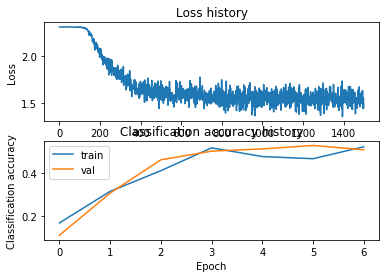

0.506
0.52
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.300919
iteration 200 / 1500: loss 2.014748
iteration 300 / 1500: loss 1.817958
iteration 400 / 1500: loss 1.634855
iteration 500 / 1500: loss 1.545817
iteration 600 / 1500: loss 1.549068
iteration 700 / 1500: loss 1.435630
iteration 800 / 1500: loss 1.532902
iteration 900 / 1500: loss 1.512736
iteration 1000 / 1500: loss 1.570747
iteration 1100 / 1500: loss 1.476888
iteration 1200 / 1500: loss 1.416245
iteration 1300 / 1500: loss 1.445951
iteration 1400 / 1500: loss 1.472640


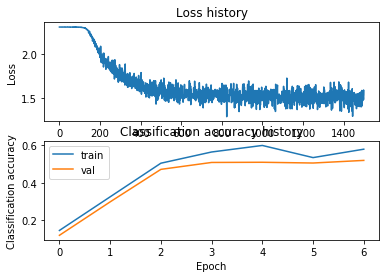

0.52
0.58
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.301330
iteration 200 / 1500: loss 2.051993
iteration 300 / 1500: loss 1.758947
iteration 400 / 1500: loss 1.611497
iteration 500 / 1500: loss 1.507420
iteration 600 / 1500: loss 1.509412
iteration 700 / 1500: loss 1.524670
iteration 800 / 1500: loss 1.564217
iteration 900 / 1500: loss 1.552288
iteration 1000 / 1500: loss 1.412921
iteration 1100 / 1500: loss 1.643623
iteration 1200 / 1500: loss 1.415883
iteration 1300 / 1500: loss 1.567315
iteration 1400 / 1500: loss 1.503492


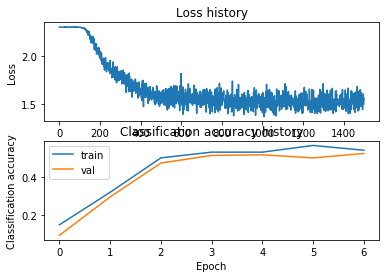

0.523
0.54
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.300009
iteration 200 / 1500: loss 1.978322
iteration 300 / 1500: loss 1.829225
iteration 400 / 1500: loss 1.699127
iteration 500 / 1500: loss 1.614048
iteration 600 / 1500: loss 1.622963
iteration 700 / 1500: loss 1.577015
iteration 800 / 1500: loss 1.557851
iteration 900 / 1500: loss 1.501640
iteration 1000 / 1500: loss 1.465681
iteration 1100 / 1500: loss 1.550188
iteration 1200 / 1500: loss 1.494136
iteration 1300 / 1500: loss 1.536785
iteration 1400 / 1500: loss 1.519178


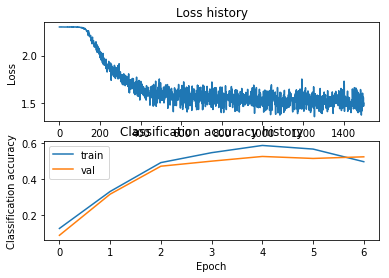

0.522
0.495
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.301961
iteration 200 / 1500: loss 2.052745
iteration 300 / 1500: loss 1.764329
iteration 400 / 1500: loss 1.686562
iteration 500 / 1500: loss 1.701828
iteration 600 / 1500: loss 1.552099
iteration 700 / 1500: loss 1.609083
iteration 800 / 1500: loss 1.545755
iteration 900 / 1500: loss 1.494546
iteration 1000 / 1500: loss 1.446027
iteration 1100 / 1500: loss 1.490839
iteration 1200 / 1500: loss 1.447949
iteration 1300 / 1500: loss 1.578869
iteration 1400 / 1500: loss 1.427650


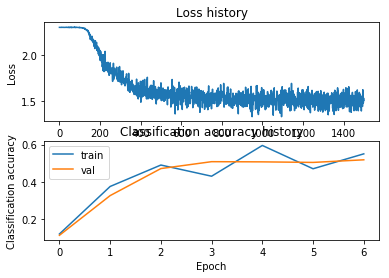

0.518
0.55
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 2.300458
iteration 200 / 1500: loss 1.962586
iteration 300 / 1500: loss 1.738647
iteration 400 / 1500: loss 1.516273
iteration 500 / 1500: loss 1.583127
iteration 600 / 1500: loss 1.591892
iteration 700 / 1500: loss 1.498413
iteration 800 / 1500: loss 1.484756
iteration 900 / 1500: loss 1.556494
iteration 1000 / 1500: loss 1.533226
iteration 1100 / 1500: loss 1.498360
iteration 1200 / 1500: loss 1.462141
iteration 1300 / 1500: loss 1.532077
iteration 1400 / 1500: loss 1.499002


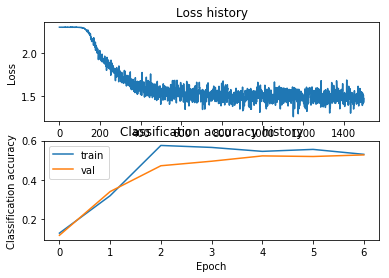

0.527
0.53
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.301547
iteration 200 / 1500: loss 2.001399
iteration 300 / 1500: loss 1.783814
iteration 400 / 1500: loss 1.602851
iteration 500 / 1500: loss 1.618664
iteration 600 / 1500: loss 1.478083
iteration 700 / 1500: loss 1.602318
iteration 800 / 1500: loss 1.613658
iteration 900 / 1500: loss 1.574111
iteration 1000 / 1500: loss 1.617889
iteration 1100 / 1500: loss 1.573491
iteration 1200 / 1500: loss 1.537022
iteration 1300 / 1500: loss 1.451549
iteration 1400 / 1500: loss 1.580967


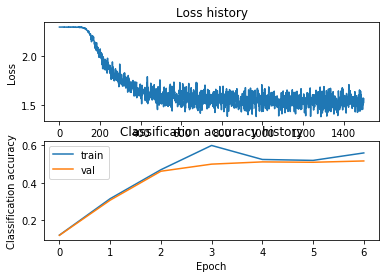

0.517
0.56
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 2.300110
iteration 200 / 1500: loss 2.007748
iteration 300 / 1500: loss 1.742370
iteration 400 / 1500: loss 1.530443
iteration 500 / 1500: loss 1.600480
iteration 600 / 1500: loss 1.534061
iteration 700 / 1500: loss 1.521770
iteration 800 / 1500: loss 1.587101
iteration 900 / 1500: loss 1.397253
iteration 1000 / 1500: loss 1.398161
iteration 1100 / 1500: loss 1.466901
iteration 1200 / 1500: loss 1.428428
iteration 1300 / 1500: loss 1.462050
iteration 1400 / 1500: loss 1.276964


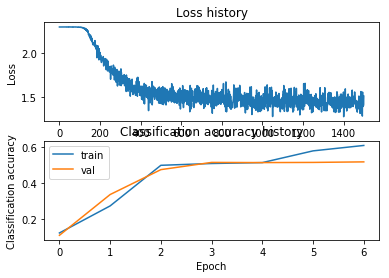

0.519
0.61
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 2.301492
iteration 200 / 1500: loss 1.975389
iteration 300 / 1500: loss 1.720247
iteration 400 / 1500: loss 1.543267
iteration 500 / 1500: loss 1.514703
iteration 600 / 1500: loss 1.487888
iteration 700 / 1500: loss 1.323085
iteration 800 / 1500: loss 1.599653
iteration 900 / 1500: loss 1.524083
iteration 1000 / 1500: loss 1.468474
iteration 1100 / 1500: loss 1.348891
iteration 1200 / 1500: loss 1.514951
iteration 1300 / 1500: loss 1.378576
iteration 1400 / 1500: loss 1.508769


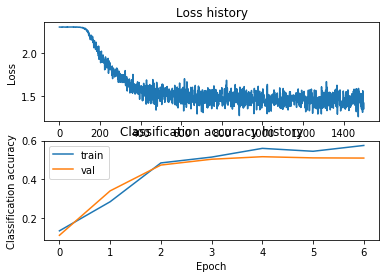

0.51
0.575
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.301406
iteration 200 / 1500: loss 2.003455
iteration 300 / 1500: loss 1.736550
iteration 400 / 1500: loss 1.680429
iteration 500 / 1500: loss 1.579865
iteration 600 / 1500: loss 1.488746
iteration 700 / 1500: loss 1.604190
iteration 800 / 1500: loss 1.514485
iteration 900 / 1500: loss 1.592357
iteration 1000 / 1500: loss 1.456586
iteration 1100 / 1500: loss 1.557451
iteration 1200 / 1500: loss 1.570184
iteration 1300 / 1500: loss 1.528016
iteration 1400 / 1500: loss 1.508697


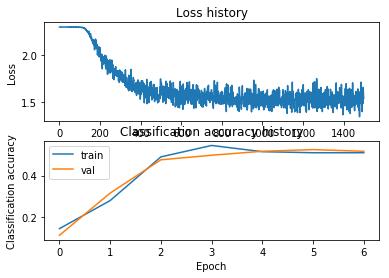

0.517
0.51
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.902215
iteration 200 / 1500: loss 1.611977
iteration 300 / 1500: loss 1.636803
iteration 400 / 1500: loss 1.655578
iteration 500 / 1500: loss 1.490232
iteration 600 / 1500: loss 1.474168
iteration 700 / 1500: loss 1.677106
iteration 800 / 1500: loss 1.604291
iteration 900 / 1500: loss 1.581456
iteration 1000 / 1500: loss 1.594081
iteration 1100 / 1500: loss 1.583114
iteration 1200 / 1500: loss 1.648631
iteration 1300 / 1500: loss 1.621283
iteration 1400 / 1500: loss 1.609090


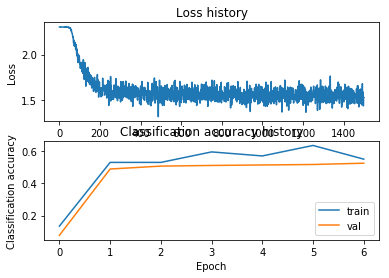

0.525
0.55
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.849125
iteration 200 / 1500: loss 1.594943
iteration 300 / 1500: loss 1.462584
iteration 400 / 1500: loss 1.691074
iteration 500 / 1500: loss 1.616204
iteration 600 / 1500: loss 1.548954
iteration 700 / 1500: loss 1.540514
iteration 800 / 1500: loss 1.548966
iteration 900 / 1500: loss 1.609513
iteration 1000 / 1500: loss 1.578432
iteration 1100 / 1500: loss 1.518901
iteration 1200 / 1500: loss 1.593710
iteration 1300 / 1500: loss 1.591729
iteration 1400 / 1500: loss 1.460421


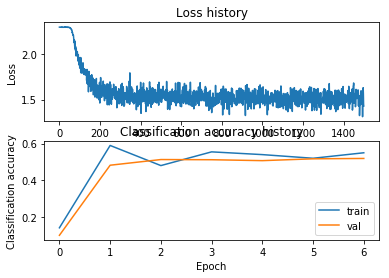

0.519
0.55
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.888069
iteration 200 / 1500: loss 1.567153
iteration 300 / 1500: loss 1.525172
iteration 400 / 1500: loss 1.572106
iteration 500 / 1500: loss 1.517530
iteration 600 / 1500: loss 1.657398
iteration 700 / 1500: loss 1.459166
iteration 800 / 1500: loss 1.481884
iteration 900 / 1500: loss 1.480684
iteration 1000 / 1500: loss 1.618018
iteration 1100 / 1500: loss 1.564026
iteration 1200 / 1500: loss 1.522172
iteration 1300 / 1500: loss 1.487505
iteration 1400 / 1500: loss 1.593764


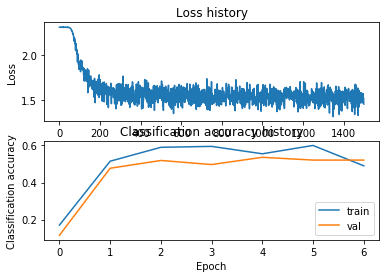

0.521
0.49
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.842548
iteration 200 / 1500: loss 1.711465
iteration 300 / 1500: loss 1.655763
iteration 400 / 1500: loss 1.592313
iteration 500 / 1500: loss 1.701025
iteration 600 / 1500: loss 1.516928
iteration 700 / 1500: loss 1.481212
iteration 800 / 1500: loss 1.604908
iteration 900 / 1500: loss 1.452595
iteration 1000 / 1500: loss 1.492334
iteration 1100 / 1500: loss 1.591430
iteration 1200 / 1500: loss 1.568293
iteration 1300 / 1500: loss 1.493911
iteration 1400 / 1500: loss 1.578152


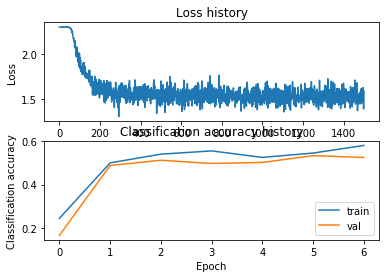

0.525
0.58
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.886466
iteration 200 / 1500: loss 1.609464
iteration 300 / 1500: loss 1.504693
iteration 400 / 1500: loss 1.555456
iteration 500 / 1500: loss 1.506122
iteration 600 / 1500: loss 1.606451
iteration 700 / 1500: loss 1.389269
iteration 800 / 1500: loss 1.439300
iteration 900 / 1500: loss 1.633567
iteration 1000 / 1500: loss 1.403928
iteration 1100 / 1500: loss 1.485578
iteration 1200 / 1500: loss 1.598567
iteration 1300 / 1500: loss 1.527671
iteration 1400 / 1500: loss 1.537182


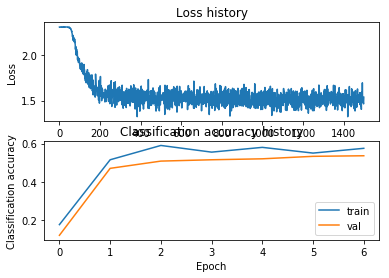

0.536
0.575
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.836259
iteration 200 / 1500: loss 1.591891
iteration 300 / 1500: loss 1.621208
iteration 400 / 1500: loss 1.472838
iteration 500 / 1500: loss 1.497911
iteration 600 / 1500: loss 1.480772
iteration 700 / 1500: loss 1.542144
iteration 800 / 1500: loss 1.377825
iteration 900 / 1500: loss 1.365337
iteration 1000 / 1500: loss 1.515975
iteration 1100 / 1500: loss 1.561830
iteration 1200 / 1500: loss 1.323474
iteration 1300 / 1500: loss 1.584314
iteration 1400 / 1500: loss 1.564829


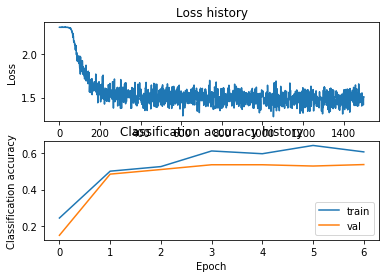

0.536
0.605
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.961982
iteration 200 / 1500: loss 1.611892
iteration 300 / 1500: loss 1.613208
iteration 400 / 1500: loss 1.535286
iteration 500 / 1500: loss 1.534243
iteration 600 / 1500: loss 1.689592
iteration 700 / 1500: loss 1.507515
iteration 800 / 1500: loss 1.527883
iteration 900 / 1500: loss 1.467157
iteration 1000 / 1500: loss 1.683005
iteration 1100 / 1500: loss 1.597110
iteration 1200 / 1500: loss 1.455007
iteration 1300 / 1500: loss 1.456475
iteration 1400 / 1500: loss 1.488947


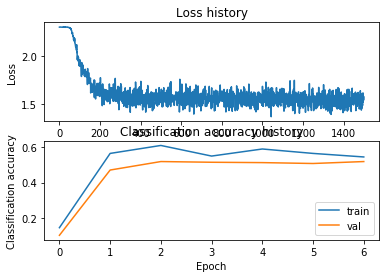

0.519
0.545
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.851246
iteration 200 / 1500: loss 1.501713
iteration 300 / 1500: loss 1.451203
iteration 400 / 1500: loss 1.588707
iteration 500 / 1500: loss 1.395880
iteration 600 / 1500: loss 1.451031
iteration 700 / 1500: loss 1.454604
iteration 800 / 1500: loss 1.430652
iteration 900 / 1500: loss 1.524436
iteration 1000 / 1500: loss 1.400277
iteration 1100 / 1500: loss 1.449949
iteration 1200 / 1500: loss 1.381905
iteration 1300 / 1500: loss 1.466558
iteration 1400 / 1500: loss 1.464366


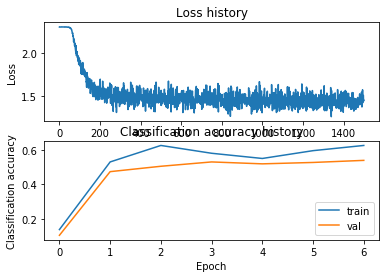

0.539
0.625
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.802645
iteration 200 / 1500: loss 1.597369
iteration 300 / 1500: loss 1.412482
iteration 400 / 1500: loss 1.539094
iteration 500 / 1500: loss 1.512268
iteration 600 / 1500: loss 1.463796
iteration 700 / 1500: loss 1.380249
iteration 800 / 1500: loss 1.505363
iteration 900 / 1500: loss 1.494005
iteration 1000 / 1500: loss 1.438501
iteration 1100 / 1500: loss 1.397404
iteration 1200 / 1500: loss 1.437226
iteration 1300 / 1500: loss 1.396681
iteration 1400 / 1500: loss 1.445908


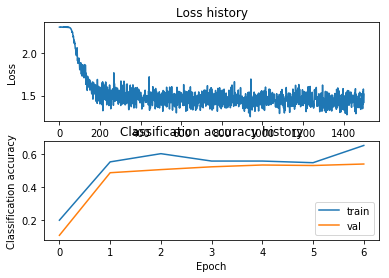

0.542
0.655
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.866894
iteration 200 / 1500: loss 1.620674
iteration 300 / 1500: loss 1.626881
iteration 400 / 1500: loss 1.566479
iteration 500 / 1500: loss 1.559225
iteration 600 / 1500: loss 1.532935
iteration 700 / 1500: loss 1.521296
iteration 800 / 1500: loss 1.468222
iteration 900 / 1500: loss 1.611143
iteration 1000 / 1500: loss 1.599991
iteration 1100 / 1500: loss 1.572027
iteration 1200 / 1500: loss 1.486840
iteration 1300 / 1500: loss 1.538180
iteration 1400 / 1500: loss 1.580072


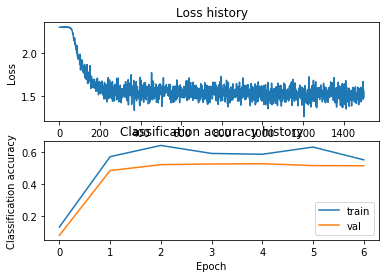

0.513
0.55
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.923102
iteration 200 / 1500: loss 1.632361
iteration 300 / 1500: loss 1.540195
iteration 400 / 1500: loss 1.561237
iteration 500 / 1500: loss 1.599873
iteration 600 / 1500: loss 1.609207
iteration 700 / 1500: loss 1.643647
iteration 800 / 1500: loss 1.579325
iteration 900 / 1500: loss 1.476373
iteration 1000 / 1500: loss 1.543948
iteration 1100 / 1500: loss 1.532601
iteration 1200 / 1500: loss 1.518454
iteration 1300 / 1500: loss 1.496018
iteration 1400 / 1500: loss 1.531377


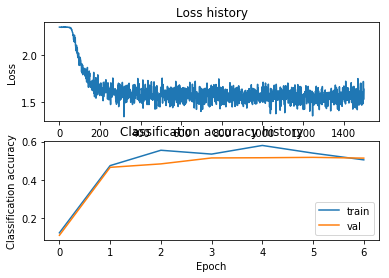

0.514
0.505
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.827441
iteration 200 / 1500: loss 1.610626
iteration 300 / 1500: loss 1.628404
iteration 400 / 1500: loss 1.492770
iteration 500 / 1500: loss 1.524104
iteration 600 / 1500: loss 1.500173
iteration 700 / 1500: loss 1.477324
iteration 800 / 1500: loss 1.612276
iteration 900 / 1500: loss 1.565829
iteration 1000 / 1500: loss 1.563531
iteration 1100 / 1500: loss 1.529820
iteration 1200 / 1500: loss 1.482147
iteration 1300 / 1500: loss 1.561368
iteration 1400 / 1500: loss 1.482889


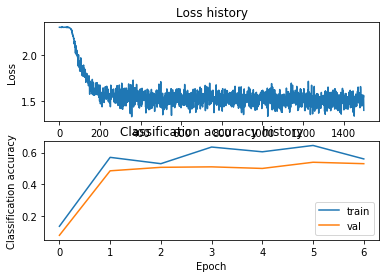

0.53
0.56
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.911547
iteration 200 / 1500: loss 1.542550
iteration 300 / 1500: loss 1.494039
iteration 400 / 1500: loss 1.494850
iteration 500 / 1500: loss 1.542955
iteration 600 / 1500: loss 1.570257
iteration 700 / 1500: loss 1.465419
iteration 800 / 1500: loss 1.725135
iteration 900 / 1500: loss 1.495127
iteration 1000 / 1500: loss 1.519085
iteration 1100 / 1500: loss 1.599532
iteration 1200 / 1500: loss 1.582135
iteration 1300 / 1500: loss 1.545047
iteration 1400 / 1500: loss 1.508069


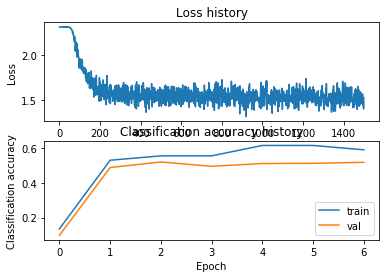

0.518
0.59
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.939430
iteration 200 / 1500: loss 1.615162
iteration 300 / 1500: loss 1.605641
iteration 400 / 1500: loss 1.501107
iteration 500 / 1500: loss 1.592866
iteration 600 / 1500: loss 1.447707
iteration 700 / 1500: loss 1.526228
iteration 800 / 1500: loss 1.502959
iteration 900 / 1500: loss 1.600423
iteration 1000 / 1500: loss 1.470887
iteration 1100 / 1500: loss 1.517718
iteration 1200 / 1500: loss 1.500006
iteration 1300 / 1500: loss 1.436723
iteration 1400 / 1500: loss 1.607472


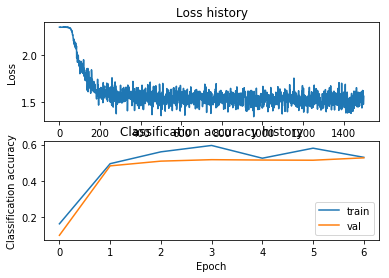

0.527
0.53
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.842416
iteration 200 / 1500: loss 1.752659
iteration 300 / 1500: loss 1.519473
iteration 400 / 1500: loss 1.513406
iteration 500 / 1500: loss 1.601196
iteration 600 / 1500: loss 1.573747
iteration 700 / 1500: loss 1.550754
iteration 800 / 1500: loss 1.448657
iteration 900 / 1500: loss 1.418116
iteration 1000 / 1500: loss 1.385596
iteration 1100 / 1500: loss 1.495758
iteration 1200 / 1500: loss 1.420078
iteration 1300 / 1500: loss 1.437779
iteration 1400 / 1500: loss 1.680515


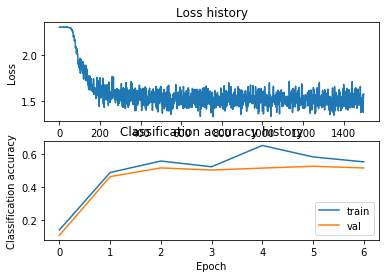

0.518
0.555
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.847131
iteration 200 / 1500: loss 1.544003
iteration 300 / 1500: loss 1.543239
iteration 400 / 1500: loss 1.625061
iteration 500 / 1500: loss 1.588960
iteration 600 / 1500: loss 1.517899
iteration 700 / 1500: loss 1.535841
iteration 800 / 1500: loss 1.498710
iteration 900 / 1500: loss 1.506452
iteration 1000 / 1500: loss 1.522612
iteration 1100 / 1500: loss 1.458638
iteration 1200 / 1500: loss 1.575483
iteration 1300 / 1500: loss 1.411332
iteration 1400 / 1500: loss 1.472014


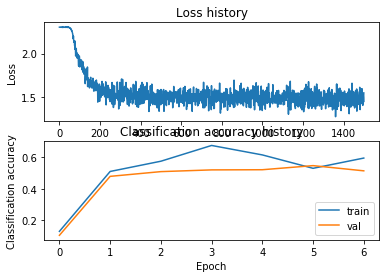

0.514
0.595
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.896379
iteration 200 / 1500: loss 1.546645
iteration 300 / 1500: loss 1.620836
iteration 400 / 1500: loss 1.611645
iteration 500 / 1500: loss 1.606017
iteration 600 / 1500: loss 1.638147
iteration 700 / 1500: loss 1.541597
iteration 800 / 1500: loss 1.541635
iteration 900 / 1500: loss 1.582544
iteration 1000 / 1500: loss 1.497656
iteration 1100 / 1500: loss 1.567293
iteration 1200 / 1500: loss 1.489704
iteration 1300 / 1500: loss 1.641841
iteration 1400 / 1500: loss 1.529920


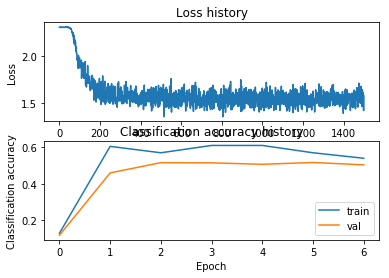

0.504
0.54
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.824499
iteration 200 / 1500: loss 1.574270
iteration 300 / 1500: loss 1.451198
iteration 400 / 1500: loss 1.378868
iteration 500 / 1500: loss 1.573433
iteration 600 / 1500: loss 1.440500
iteration 700 / 1500: loss 1.562752
iteration 800 / 1500: loss 1.500904
iteration 900 / 1500: loss 1.471235
iteration 1000 / 1500: loss 1.390062
iteration 1100 / 1500: loss 1.431381
iteration 1200 / 1500: loss 1.453738
iteration 1300 / 1500: loss 1.478438
iteration 1400 / 1500: loss 1.425039


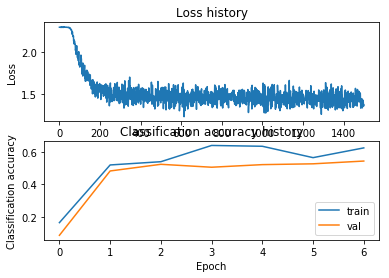

0.544
0.625
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.944183
iteration 200 / 1500: loss 1.551327
iteration 300 / 1500: loss 1.537473
iteration 400 / 1500: loss 1.463793
iteration 500 / 1500: loss 1.463586
iteration 600 / 1500: loss 1.473837
iteration 700 / 1500: loss 1.510595
iteration 800 / 1500: loss 1.569733
iteration 900 / 1500: loss 1.402597
iteration 1000 / 1500: loss 1.426673
iteration 1100 / 1500: loss 1.553687
iteration 1200 / 1500: loss 1.400981
iteration 1300 / 1500: loss 1.326027
iteration 1400 / 1500: loss 1.437802


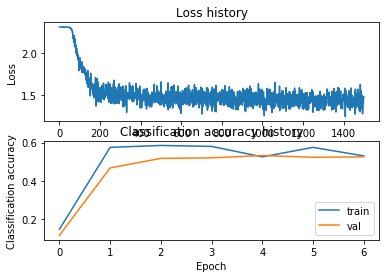

0.525
0.53
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.936690
iteration 200 / 1500: loss 1.671804
iteration 300 / 1500: loss 1.552056
iteration 400 / 1500: loss 1.537234
iteration 500 / 1500: loss 1.646962
iteration 600 / 1500: loss 1.544494
iteration 700 / 1500: loss 1.498679
iteration 800 / 1500: loss 1.481938
iteration 900 / 1500: loss 1.533085
iteration 1000 / 1500: loss 1.520536
iteration 1100 / 1500: loss 1.520768
iteration 1200 / 1500: loss 1.498350
iteration 1300 / 1500: loss 1.546006
iteration 1400 / 1500: loss 1.557725


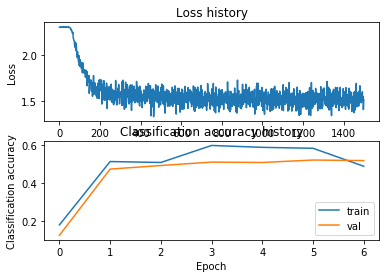

0.52
0.49
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.807984
iteration 200 / 1500: loss 1.714817
iteration 300 / 1500: loss 1.663554
iteration 400 / 1500: loss 1.558648
iteration 500 / 1500: loss 1.580851
iteration 600 / 1500: loss 1.540852
iteration 700 / 1500: loss 1.519716
iteration 800 / 1500: loss 1.469379
iteration 900 / 1500: loss 1.626298
iteration 1000 / 1500: loss 1.592184
iteration 1100 / 1500: loss 1.498505
iteration 1200 / 1500: loss 1.609500
iteration 1300 / 1500: loss 1.494014
iteration 1400 / 1500: loss 1.529198


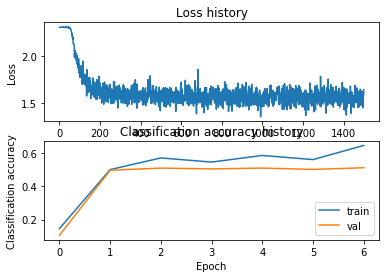

0.511
0.645
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.862868
iteration 200 / 1500: loss 1.570761
iteration 300 / 1500: loss 1.491990
iteration 400 / 1500: loss 1.508573
iteration 500 / 1500: loss 1.674589
iteration 600 / 1500: loss 1.623660
iteration 700 / 1500: loss 1.480594
iteration 800 / 1500: loss 1.581407
iteration 900 / 1500: loss 1.466359
iteration 1000 / 1500: loss 1.410878
iteration 1100 / 1500: loss 1.541452
iteration 1200 / 1500: loss 1.598487
iteration 1300 / 1500: loss 1.597361
iteration 1400 / 1500: loss 1.458711


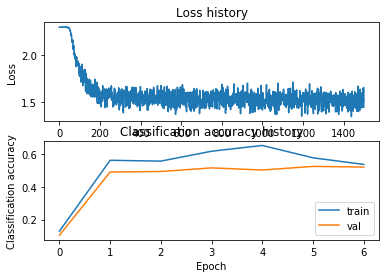

0.519
0.535
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.825261
iteration 200 / 1500: loss 1.497076
iteration 300 / 1500: loss 1.644906
iteration 400 / 1500: loss 1.513528
iteration 500 / 1500: loss 1.567062
iteration 600 / 1500: loss 1.507080
iteration 700 / 1500: loss 1.718753
iteration 800 / 1500: loss 1.568666
iteration 900 / 1500: loss 1.477872
iteration 1000 / 1500: loss 1.459334
iteration 1100 / 1500: loss 1.567353
iteration 1200 / 1500: loss 1.523938
iteration 1300 / 1500: loss 1.570807
iteration 1400 / 1500: loss 1.561645


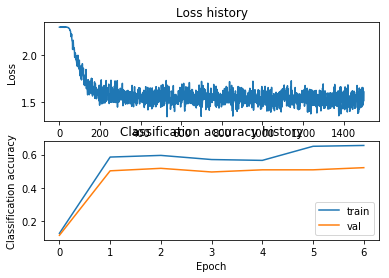

0.521
0.655
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.862938
iteration 200 / 1500: loss 1.576422
iteration 300 / 1500: loss 1.605504
iteration 400 / 1500: loss 1.546813
iteration 500 / 1500: loss 1.486012
iteration 600 / 1500: loss 1.542345
iteration 700 / 1500: loss 1.616009
iteration 800 / 1500: loss 1.538852
iteration 900 / 1500: loss 1.592158
iteration 1000 / 1500: loss 1.592521
iteration 1100 / 1500: loss 1.528485
iteration 1200 / 1500: loss 1.546732
iteration 1300 / 1500: loss 1.532459
iteration 1400 / 1500: loss 1.587964


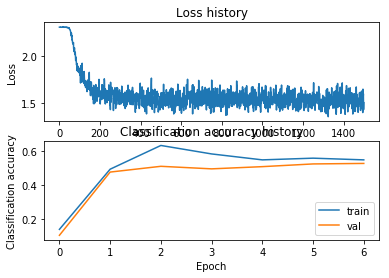

0.529
0.55
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.905142
iteration 200 / 1500: loss 1.608874
iteration 300 / 1500: loss 1.571542
iteration 400 / 1500: loss 1.612674
iteration 500 / 1500: loss 1.410446
iteration 600 / 1500: loss 1.455716
iteration 700 / 1500: loss 1.705639
iteration 800 / 1500: loss 1.547239
iteration 900 / 1500: loss 1.438780
iteration 1000 / 1500: loss 1.479813
iteration 1100 / 1500: loss 1.415187
iteration 1200 / 1500: loss 1.472192
iteration 1300 / 1500: loss 1.407514
iteration 1400 / 1500: loss 1.388218


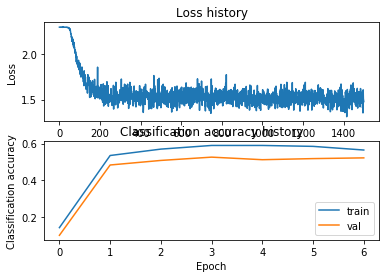

0.522
0.565
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.797976
iteration 200 / 1500: loss 1.570009
iteration 300 / 1500: loss 1.488795
iteration 400 / 1500: loss 1.559756
iteration 500 / 1500: loss 1.551057
iteration 600 / 1500: loss 1.484013
iteration 700 / 1500: loss 1.461466
iteration 800 / 1500: loss 1.451482
iteration 900 / 1500: loss 1.508969
iteration 1000 / 1500: loss 1.408352
iteration 1100 / 1500: loss 1.499711
iteration 1200 / 1500: loss 1.421264
iteration 1300 / 1500: loss 1.534382
iteration 1400 / 1500: loss 1.529464


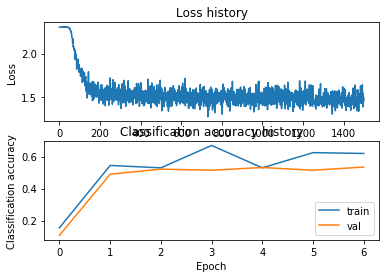

0.535
0.62
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.829781
iteration 200 / 1500: loss 1.619088
iteration 300 / 1500: loss 1.673657
iteration 400 / 1500: loss 1.492512
iteration 500 / 1500: loss 1.620515
iteration 600 / 1500: loss 1.514005
iteration 700 / 1500: loss 1.560418
iteration 800 / 1500: loss 1.596889
iteration 900 / 1500: loss 1.542713
iteration 1000 / 1500: loss 1.512282
iteration 1100 / 1500: loss 1.539437
iteration 1200 / 1500: loss 1.489766
iteration 1300 / 1500: loss 1.394366
iteration 1400 / 1500: loss 1.497920


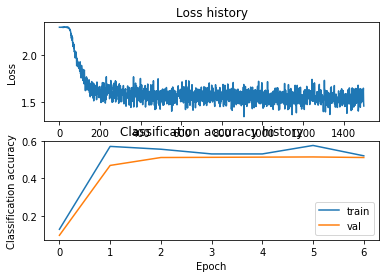

0.511
0.52
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.778980
iteration 200 / 1500: loss 1.516714
iteration 300 / 1500: loss 1.522940
iteration 400 / 1500: loss 1.472786
iteration 500 / 1500: loss 1.403137
iteration 600 / 1500: loss 1.568297
iteration 700 / 1500: loss 1.593663
iteration 800 / 1500: loss 1.469541
iteration 900 / 1500: loss 1.265621
iteration 1000 / 1500: loss 1.515052
iteration 1100 / 1500: loss 1.475086
iteration 1200 / 1500: loss 1.480831
iteration 1300 / 1500: loss 1.403309
iteration 1400 / 1500: loss 1.464805


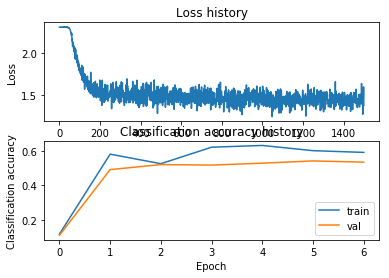

0.534
0.59
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.779412
iteration 200 / 1500: loss 1.597776
iteration 300 / 1500: loss 1.452053
iteration 400 / 1500: loss 1.484630
iteration 500 / 1500: loss 1.587624
iteration 600 / 1500: loss 1.544959
iteration 700 / 1500: loss 1.444221
iteration 800 / 1500: loss 1.508173
iteration 900 / 1500: loss 1.438216
iteration 1000 / 1500: loss 1.427586
iteration 1100 / 1500: loss 1.411852
iteration 1200 / 1500: loss 1.473493
iteration 1300 / 1500: loss 1.421148
iteration 1400 / 1500: loss 1.603592


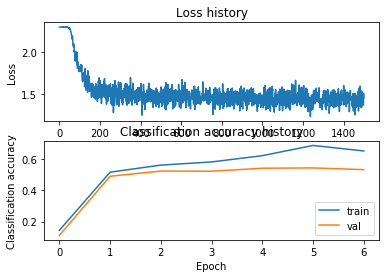

0.531
0.65
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.830302
iteration 200 / 1500: loss 1.573985
iteration 300 / 1500: loss 1.562720
iteration 400 / 1500: loss 1.516469
iteration 500 / 1500: loss 1.611736
iteration 600 / 1500: loss 1.583069
iteration 700 / 1500: loss 1.663258
iteration 800 / 1500: loss 1.601745
iteration 900 / 1500: loss 1.617851
iteration 1000 / 1500: loss 1.399150
iteration 1100 / 1500: loss 1.597376
iteration 1200 / 1500: loss 1.527559
iteration 1300 / 1500: loss 1.447404
iteration 1400 / 1500: loss 1.480895


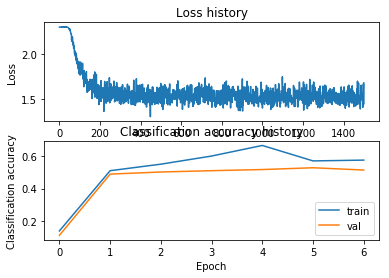

0.514
0.575
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 2.041288
iteration 200 / 1500: loss 1.624646
iteration 300 / 1500: loss 1.610181
iteration 400 / 1500: loss 1.564076
iteration 500 / 1500: loss 1.516025
iteration 600 / 1500: loss 1.649851
iteration 700 / 1500: loss 1.528454
iteration 800 / 1500: loss 1.574114
iteration 900 / 1500: loss 1.530696
iteration 1000 / 1500: loss 1.556970
iteration 1100 / 1500: loss 1.494126
iteration 1200 / 1500: loss 1.562562
iteration 1300 / 1500: loss 1.592655
iteration 1400 / 1500: loss 1.521249


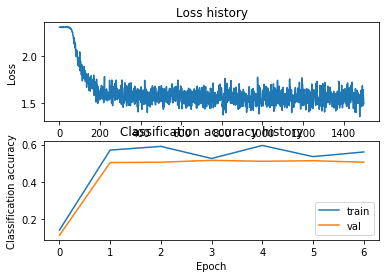

0.505
0.56
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.933539
iteration 200 / 1500: loss 1.653265
iteration 300 / 1500: loss 1.491562
iteration 400 / 1500: loss 1.612483
iteration 500 / 1500: loss 1.573972
iteration 600 / 1500: loss 1.439488
iteration 700 / 1500: loss 1.561509
iteration 800 / 1500: loss 1.510051
iteration 900 / 1500: loss 1.530823
iteration 1000 / 1500: loss 1.599521
iteration 1100 / 1500: loss 1.563875
iteration 1200 / 1500: loss 1.564399
iteration 1300 / 1500: loss 1.509633
iteration 1400 / 1500: loss 1.428901


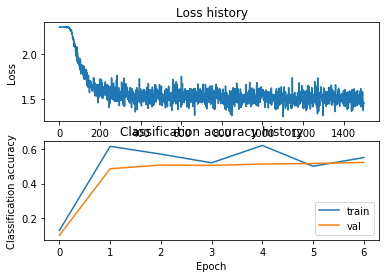

0.522
0.55
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.902925
iteration 200 / 1500: loss 1.641501
iteration 300 / 1500: loss 1.593728
iteration 400 / 1500: loss 1.532893
iteration 500 / 1500: loss 1.593543
iteration 600 / 1500: loss 1.543543
iteration 700 / 1500: loss 1.531956
iteration 800 / 1500: loss 1.643451
iteration 900 / 1500: loss 1.673794
iteration 1000 / 1500: loss 1.459231
iteration 1100 / 1500: loss 1.672928
iteration 1200 / 1500: loss 1.485813
iteration 1300 / 1500: loss 1.560502
iteration 1400 / 1500: loss 1.624941


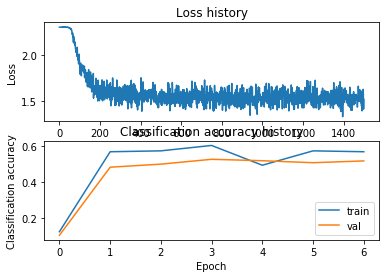

0.519
0.57
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.879680
iteration 200 / 1500: loss 1.610718
iteration 300 / 1500: loss 1.587284
iteration 400 / 1500: loss 1.477506
iteration 500 / 1500: loss 1.528547
iteration 600 / 1500: loss 1.556134
iteration 700 / 1500: loss 1.400433
iteration 800 / 1500: loss 1.444272
iteration 900 / 1500: loss 1.541215
iteration 1000 / 1500: loss 1.402534
iteration 1100 / 1500: loss 1.499359
iteration 1200 / 1500: loss 1.557033
iteration 1300 / 1500: loss 1.612580
iteration 1400 / 1500: loss 1.455213


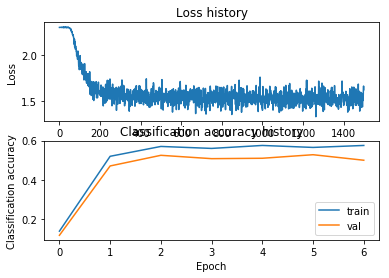

0.5
0.575
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.827538
iteration 200 / 1500: loss 1.648233
iteration 300 / 1500: loss 1.546295
iteration 400 / 1500: loss 1.475211
iteration 500 / 1500: loss 1.438844
iteration 600 / 1500: loss 1.593075
iteration 700 / 1500: loss 1.587786
iteration 800 / 1500: loss 1.585018
iteration 900 / 1500: loss 1.393241
iteration 1000 / 1500: loss 1.507048
iteration 1100 / 1500: loss 1.514459
iteration 1200 / 1500: loss 1.440448
iteration 1300 / 1500: loss 1.420449
iteration 1400 / 1500: loss 1.536289


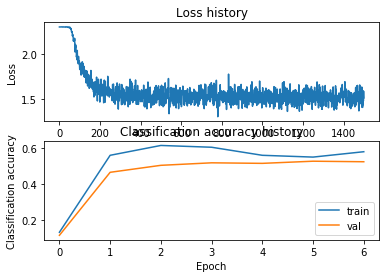

0.524
0.58
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.911229
iteration 200 / 1500: loss 1.534520
iteration 300 / 1500: loss 1.547299
iteration 400 / 1500: loss 1.410825
iteration 500 / 1500: loss 1.578182
iteration 600 / 1500: loss 1.518257
iteration 700 / 1500: loss 1.561127
iteration 800 / 1500: loss 1.361305
iteration 900 / 1500: loss 1.481318
iteration 1000 / 1500: loss 1.552317
iteration 1100 / 1500: loss 1.519237
iteration 1200 / 1500: loss 1.523834
iteration 1300 / 1500: loss 1.455096
iteration 1400 / 1500: loss 1.513832


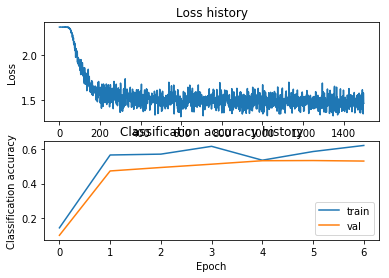

0.53
0.62
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.892954
iteration 200 / 1500: loss 1.578266
iteration 300 / 1500: loss 1.597086
iteration 400 / 1500: loss 1.635526
iteration 500 / 1500: loss 1.578322
iteration 600 / 1500: loss 1.650951
iteration 700 / 1500: loss 1.526155
iteration 800 / 1500: loss 1.519015
iteration 900 / 1500: loss 1.478974
iteration 1000 / 1500: loss 1.612299
iteration 1100 / 1500: loss 1.488216
iteration 1200 / 1500: loss 1.500596
iteration 1300 / 1500: loss 1.500752
iteration 1400 / 1500: loss 1.531032


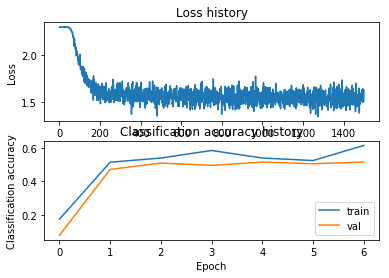

0.516
0.615
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.926331
iteration 200 / 1500: loss 1.568820
iteration 300 / 1500: loss 1.517245
iteration 400 / 1500: loss 1.437485
iteration 500 / 1500: loss 1.498045
iteration 600 / 1500: loss 1.529518
iteration 700 / 1500: loss 1.606304
iteration 800 / 1500: loss 1.461895
iteration 900 / 1500: loss 1.479583
iteration 1000 / 1500: loss 1.453532
iteration 1100 / 1500: loss 1.447121
iteration 1200 / 1500: loss 1.461861
iteration 1300 / 1500: loss 1.417060
iteration 1400 / 1500: loss 1.490698


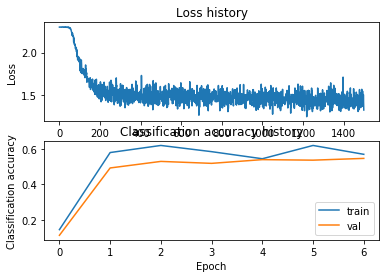

0.547
0.57
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.827544
iteration 200 / 1500: loss 1.441130
iteration 300 / 1500: loss 1.435299
iteration 400 / 1500: loss 1.375399
iteration 500 / 1500: loss 1.525896
iteration 600 / 1500: loss 1.463339
iteration 700 / 1500: loss 1.500112
iteration 800 / 1500: loss 1.356503
iteration 900 / 1500: loss 1.418872
iteration 1000 / 1500: loss 1.473408
iteration 1100 / 1500: loss 1.368656
iteration 1200 / 1500: loss 1.442967
iteration 1300 / 1500: loss 1.373512
iteration 1400 / 1500: loss 1.380888


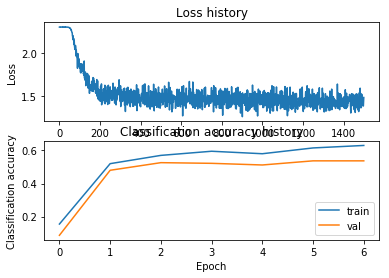

0.537
0.63
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.875227
iteration 200 / 1500: loss 1.721241
iteration 300 / 1500: loss 1.615541
iteration 400 / 1500: loss 1.497786
iteration 500 / 1500: loss 1.590876
iteration 600 / 1500: loss 1.497621
iteration 700 / 1500: loss 1.576156
iteration 800 / 1500: loss 1.385551
iteration 900 / 1500: loss 1.466346
iteration 1000 / 1500: loss 1.451585
iteration 1100 / 1500: loss 1.456737
iteration 1200 / 1500: loss 1.464325
iteration 1300 / 1500: loss 1.574198
iteration 1400 / 1500: loss 1.559949


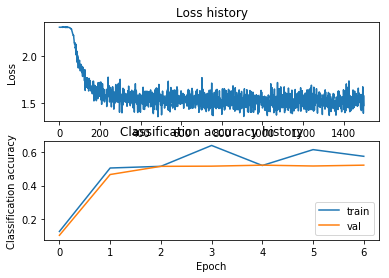

0.522
0.575
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.852322
iteration 200 / 1500: loss 1.680336
iteration 300 / 1500: loss 1.638700
iteration 400 / 1500: loss 1.625226
iteration 500 / 1500: loss 1.407137
iteration 600 / 1500: loss 1.654339
iteration 700 / 1500: loss 1.662205
iteration 800 / 1500: loss 1.520819
iteration 900 / 1500: loss 1.579568
iteration 1000 / 1500: loss 1.488445
iteration 1100 / 1500: loss 1.541052
iteration 1200 / 1500: loss 1.558714
iteration 1300 / 1500: loss 1.556060
iteration 1400 / 1500: loss 1.549147


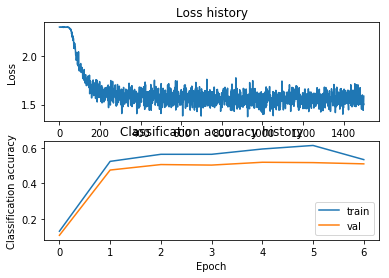

0.511
0.535
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.902375
iteration 200 / 1500: loss 1.631278
iteration 300 / 1500: loss 1.580806
iteration 400 / 1500: loss 1.543868
iteration 500 / 1500: loss 1.554087
iteration 600 / 1500: loss 1.504386
iteration 700 / 1500: loss 1.580204
iteration 800 / 1500: loss 1.484826
iteration 900 / 1500: loss 1.619728
iteration 1000 / 1500: loss 1.505246
iteration 1100 / 1500: loss 1.553860
iteration 1200 / 1500: loss 1.498320
iteration 1300 / 1500: loss 1.480120
iteration 1400 / 1500: loss 1.507527


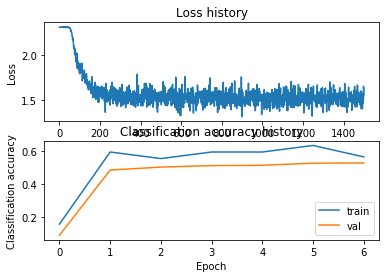

0.528
0.565
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.883208
iteration 200 / 1500: loss 1.716956
iteration 300 / 1500: loss 1.612799
iteration 400 / 1500: loss 1.569771
iteration 500 / 1500: loss 1.547764
iteration 600 / 1500: loss 1.513877
iteration 700 / 1500: loss 1.494849
iteration 800 / 1500: loss 1.527167
iteration 900 / 1500: loss 1.518789
iteration 1000 / 1500: loss 1.540491
iteration 1100 / 1500: loss 1.681389
iteration 1200 / 1500: loss 1.554476
iteration 1300 / 1500: loss 1.482662
iteration 1400 / 1500: loss 1.552303


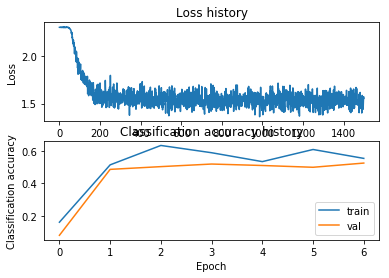

0.526
0.555
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.930037
iteration 200 / 1500: loss 1.655635
iteration 300 / 1500: loss 1.545508
iteration 400 / 1500: loss 1.563960
iteration 500 / 1500: loss 1.420301
iteration 600 / 1500: loss 1.657697
iteration 700 / 1500: loss 1.467863
iteration 800 / 1500: loss 1.521723
iteration 900 / 1500: loss 1.553006
iteration 1000 / 1500: loss 1.537681
iteration 1100 / 1500: loss 1.583043
iteration 1200 / 1500: loss 1.497837
iteration 1300 / 1500: loss 1.565135
iteration 1400 / 1500: loss 1.557194


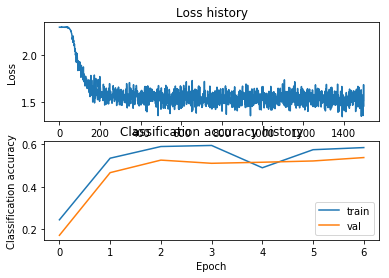

0.538
0.585
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.920804
iteration 200 / 1500: loss 1.489779
iteration 300 / 1500: loss 1.684656
iteration 400 / 1500: loss 1.527859
iteration 500 / 1500: loss 1.508865
iteration 600 / 1500: loss 1.475437
iteration 700 / 1500: loss 1.448880
iteration 800 / 1500: loss 1.568409
iteration 900 / 1500: loss 1.552041
iteration 1000 / 1500: loss 1.530868
iteration 1100 / 1500: loss 1.503188
iteration 1200 / 1500: loss 1.559255
iteration 1300 / 1500: loss 1.416372
iteration 1400 / 1500: loss 1.449263


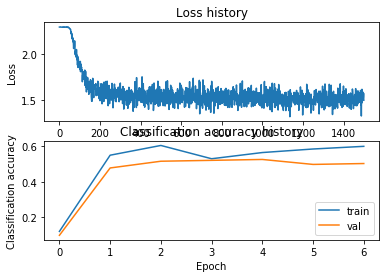

0.503
0.6
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.913803
iteration 200 / 1500: loss 1.547690
iteration 300 / 1500: loss 1.529278
iteration 400 / 1500: loss 1.556974
iteration 500 / 1500: loss 1.427694
iteration 600 / 1500: loss 1.560531
iteration 700 / 1500: loss 1.525548
iteration 800 / 1500: loss 1.463922
iteration 900 / 1500: loss 1.447702
iteration 1000 / 1500: loss 1.468766
iteration 1100 / 1500: loss 1.526823
iteration 1200 / 1500: loss 1.558162
iteration 1300 / 1500: loss 1.592951
iteration 1400 / 1500: loss 1.395391


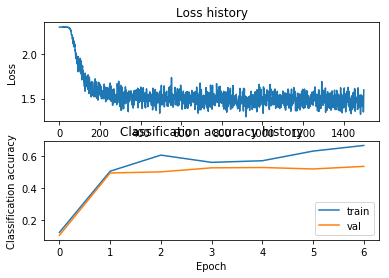

0.535
0.665
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.875334
iteration 200 / 1500: loss 1.644540
iteration 300 / 1500: loss 1.573350
iteration 400 / 1500: loss 1.505822
iteration 500 / 1500: loss 1.713854
iteration 600 / 1500: loss 1.589522
iteration 700 / 1500: loss 1.485105
iteration 800 / 1500: loss 1.529321
iteration 900 / 1500: loss 1.491101
iteration 1000 / 1500: loss 1.576607
iteration 1100 / 1500: loss 1.561691
iteration 1200 / 1500: loss 1.479583
iteration 1300 / 1500: loss 1.547030
iteration 1400 / 1500: loss 1.605804


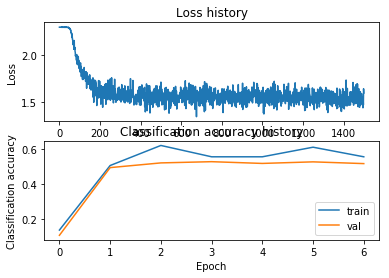

0.516
0.555
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.822127
iteration 200 / 1500: loss 1.565466
iteration 300 / 1500: loss 1.572426
iteration 400 / 1500: loss 1.430310
iteration 500 / 1500: loss 1.365441
iteration 600 / 1500: loss 1.467389
iteration 700 / 1500: loss 1.542640
iteration 800 / 1500: loss 1.552073
iteration 900 / 1500: loss 1.473041
iteration 1000 / 1500: loss 1.401209
iteration 1100 / 1500: loss 1.458156
iteration 1200 / 1500: loss 1.471760
iteration 1300 / 1500: loss 1.452589
iteration 1400 / 1500: loss 1.486215


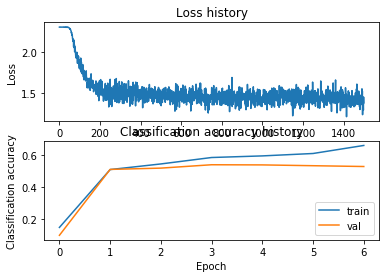

0.529
0.66
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.816218
iteration 200 / 1500: loss 1.524954
iteration 300 / 1500: loss 1.615654
iteration 400 / 1500: loss 1.473681
iteration 500 / 1500: loss 1.371817
iteration 600 / 1500: loss 1.447349
iteration 700 / 1500: loss 1.404271
iteration 800 / 1500: loss 1.345139
iteration 900 / 1500: loss 1.369298
iteration 1000 / 1500: loss 1.436859
iteration 1100 / 1500: loss 1.358269
iteration 1200 / 1500: loss 1.474277
iteration 1300 / 1500: loss 1.527929
iteration 1400 / 1500: loss 1.422478


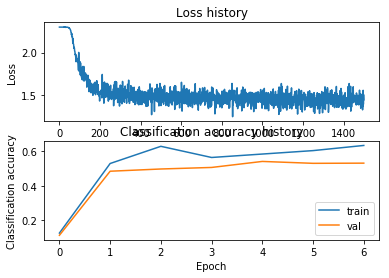

0.532
0.635
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.890426
iteration 200 / 1500: loss 1.541853
iteration 300 / 1500: loss 1.551074
iteration 400 / 1500: loss 1.478643
iteration 500 / 1500: loss 1.540522
iteration 600 / 1500: loss 1.510328
iteration 700 / 1500: loss 1.632193
iteration 800 / 1500: loss 1.581622
iteration 900 / 1500: loss 1.559018
iteration 1000 / 1500: loss 1.419423
iteration 1100 / 1500: loss 1.552824
iteration 1200 / 1500: loss 1.495829
iteration 1300 / 1500: loss 1.492090
iteration 1400 / 1500: loss 1.538198


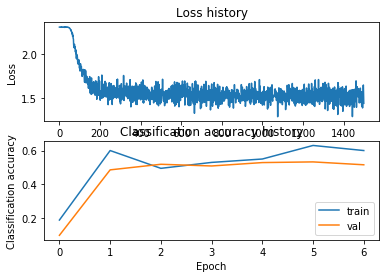

0.516
0.6
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 2.071692
iteration 200 / 1500: loss 1.704686
iteration 300 / 1500: loss 1.754181
iteration 400 / 1500: loss 1.610534
iteration 500 / 1500: loss 1.545514
iteration 600 / 1500: loss 1.612019
iteration 700 / 1500: loss 1.576684
iteration 800 / 1500: loss 1.623219
iteration 900 / 1500: loss 1.492063
iteration 1000 / 1500: loss 1.632978
iteration 1100 / 1500: loss 1.462685
iteration 1200 / 1500: loss 1.460600
iteration 1300 / 1500: loss 1.510581
iteration 1400 / 1500: loss 1.552895


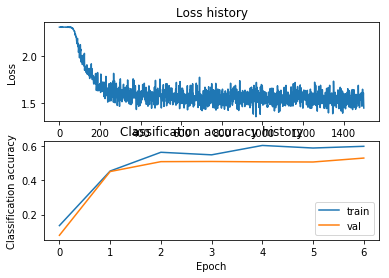

0.531
0.6
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.018061
iteration 200 / 1500: loss 1.547910
iteration 300 / 1500: loss 1.562298
iteration 400 / 1500: loss 1.524492
iteration 500 / 1500: loss 1.583699
iteration 600 / 1500: loss 1.583100
iteration 700 / 1500: loss 1.544453
iteration 800 / 1500: loss 1.483234
iteration 900 / 1500: loss 1.505488
iteration 1000 / 1500: loss 1.508424
iteration 1100 / 1500: loss 1.465176
iteration 1200 / 1500: loss 1.486481
iteration 1300 / 1500: loss 1.547219
iteration 1400 / 1500: loss 1.433259


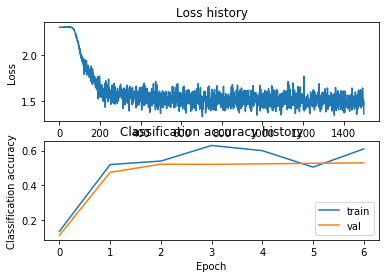

0.53
0.61
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.063090
iteration 200 / 1500: loss 1.669422
iteration 300 / 1500: loss 1.598529
iteration 400 / 1500: loss 1.576113
iteration 500 / 1500: loss 1.573254
iteration 600 / 1500: loss 1.394932
iteration 700 / 1500: loss 1.626637
iteration 800 / 1500: loss 1.605537
iteration 900 / 1500: loss 1.651722
iteration 1000 / 1500: loss 1.417324
iteration 1100 / 1500: loss 1.576618
iteration 1200 / 1500: loss 1.392748
iteration 1300 / 1500: loss 1.515612
iteration 1400 / 1500: loss 1.533644


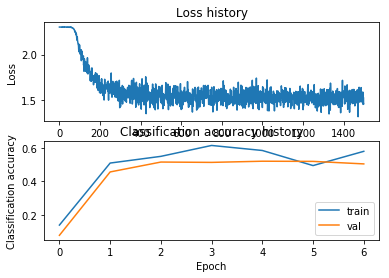

0.505
0.58
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.042210
iteration 200 / 1500: loss 1.639797
iteration 300 / 1500: loss 1.493175
iteration 400 / 1500: loss 1.501164
iteration 500 / 1500: loss 1.513016
iteration 600 / 1500: loss 1.377368
iteration 700 / 1500: loss 1.634921
iteration 800 / 1500: loss 1.495330
iteration 900 / 1500: loss 1.516836
iteration 1000 / 1500: loss 1.465613
iteration 1100 / 1500: loss 1.585860
iteration 1200 / 1500: loss 1.459347
iteration 1300 / 1500: loss 1.582566
iteration 1400 / 1500: loss 1.518080


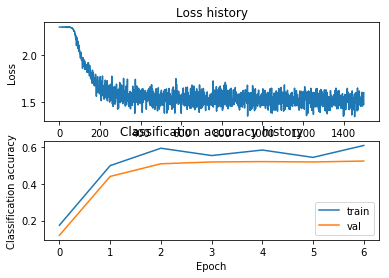

0.525
0.61
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.064176
iteration 200 / 1500: loss 1.636986
iteration 300 / 1500: loss 1.589843
iteration 400 / 1500: loss 1.577674
iteration 500 / 1500: loss 1.381380
iteration 600 / 1500: loss 1.520433
iteration 700 / 1500: loss 1.515202
iteration 800 / 1500: loss 1.455325
iteration 900 / 1500: loss 1.629581
iteration 1000 / 1500: loss 1.535595
iteration 1100 / 1500: loss 1.437692
iteration 1200 / 1500: loss 1.433294
iteration 1300 / 1500: loss 1.562694
iteration 1400 / 1500: loss 1.522229


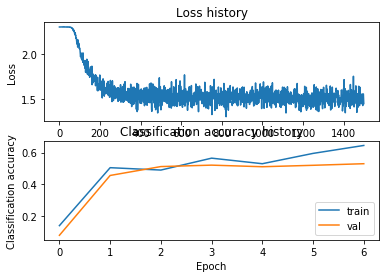

0.53
0.645
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 2.023317
iteration 200 / 1500: loss 1.612555
iteration 300 / 1500: loss 1.604123
iteration 400 / 1500: loss 1.487640
iteration 500 / 1500: loss 1.408865
iteration 600 / 1500: loss 1.564450
iteration 700 / 1500: loss 1.467794
iteration 800 / 1500: loss 1.476850
iteration 900 / 1500: loss 1.539291
iteration 1000 / 1500: loss 1.558536
iteration 1100 / 1500: loss 1.357099
iteration 1200 / 1500: loss 1.562711
iteration 1300 / 1500: loss 1.556032
iteration 1400 / 1500: loss 1.478619


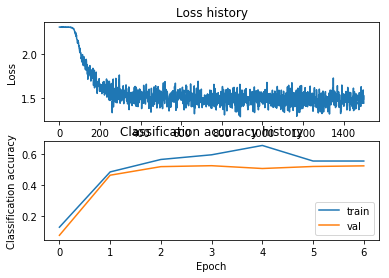

0.524
0.555
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 2.088919
iteration 200 / 1500: loss 1.665290
iteration 300 / 1500: loss 1.634309
iteration 400 / 1500: loss 1.544577
iteration 500 / 1500: loss 1.501130
iteration 600 / 1500: loss 1.567125
iteration 700 / 1500: loss 1.515903
iteration 800 / 1500: loss 1.449678
iteration 900 / 1500: loss 1.410253
iteration 1000 / 1500: loss 1.621662
iteration 1100 / 1500: loss 1.514768
iteration 1200 / 1500: loss 1.585895
iteration 1300 / 1500: loss 1.664693
iteration 1400 / 1500: loss 1.445144


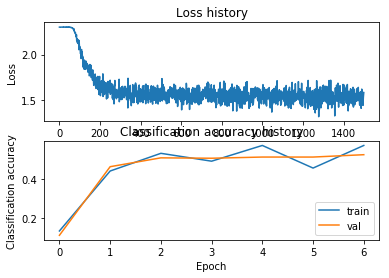

0.523
0.57
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 2.053398
iteration 200 / 1500: loss 1.644545
iteration 300 / 1500: loss 1.447742
iteration 400 / 1500: loss 1.635416
iteration 500 / 1500: loss 1.500765
iteration 600 / 1500: loss 1.470936
iteration 700 / 1500: loss 1.345071
iteration 800 / 1500: loss 1.478205
iteration 900 / 1500: loss 1.540615
iteration 1000 / 1500: loss 1.450476
iteration 1100 / 1500: loss 1.512830
iteration 1200 / 1500: loss 1.317359
iteration 1300 / 1500: loss 1.402855
iteration 1400 / 1500: loss 1.473417


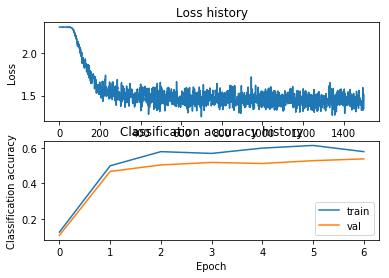

0.539
0.58
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 2.068499
iteration 200 / 1500: loss 1.722155
iteration 300 / 1500: loss 1.475799
iteration 400 / 1500: loss 1.526447
iteration 500 / 1500: loss 1.483588
iteration 600 / 1500: loss 1.430935
iteration 700 / 1500: loss 1.535600
iteration 800 / 1500: loss 1.369130
iteration 900 / 1500: loss 1.492330
iteration 1000 / 1500: loss 1.413452
iteration 1100 / 1500: loss 1.514724
iteration 1200 / 1500: loss 1.356323
iteration 1300 / 1500: loss 1.589072
iteration 1400 / 1500: loss 1.488322


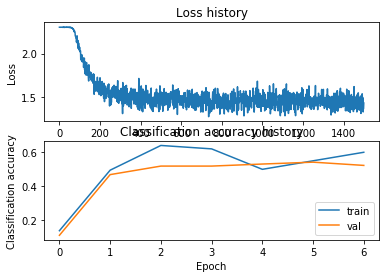

0.523
0.6
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 2.061043
iteration 200 / 1500: loss 1.685025
iteration 300 / 1500: loss 1.526996
iteration 400 / 1500: loss 1.570476
iteration 500 / 1500: loss 1.494926
iteration 600 / 1500: loss 1.591139
iteration 700 / 1500: loss 1.559494
iteration 800 / 1500: loss 1.546784
iteration 900 / 1500: loss 1.613892
iteration 1000 / 1500: loss 1.542327
iteration 1100 / 1500: loss 1.692008
iteration 1200 / 1500: loss 1.479007
iteration 1300 / 1500: loss 1.491927
iteration 1400 / 1500: loss 1.365995


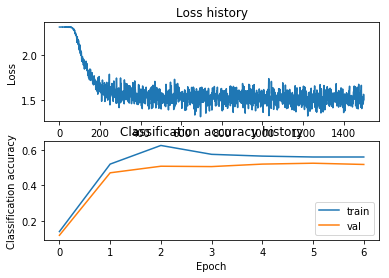

0.518
0.56
iteration 0 / 1500: loss 2.302594
iteration 100 / 1500: loss 1.851520
iteration 200 / 1500: loss 1.488768
iteration 300 / 1500: loss 1.493970
iteration 400 / 1500: loss 1.432391
iteration 500 / 1500: loss 1.555051
iteration 600 / 1500: loss 1.531233
iteration 700 / 1500: loss 1.470061
iteration 800 / 1500: loss 1.566382
iteration 900 / 1500: loss 1.655770
iteration 1000 / 1500: loss 1.593086
iteration 1100 / 1500: loss 1.538987
iteration 1200 / 1500: loss 1.688889
iteration 1300 / 1500: loss 1.696616
iteration 1400 / 1500: loss 1.608650


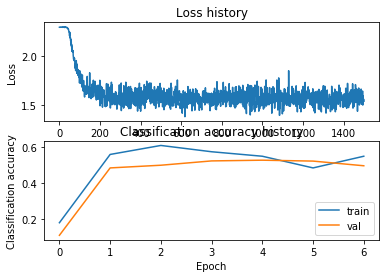

0.497
0.55
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.749023
iteration 200 / 1500: loss 1.667568
iteration 300 / 1500: loss 1.535346
iteration 400 / 1500: loss 1.541688
iteration 500 / 1500: loss 1.515857
iteration 600 / 1500: loss 1.590861
iteration 700 / 1500: loss 1.544195
iteration 800 / 1500: loss 1.614297
iteration 900 / 1500: loss 1.515912
iteration 1000 / 1500: loss 1.466478
iteration 1100 / 1500: loss 1.444867
iteration 1200 / 1500: loss 1.481608
iteration 1300 / 1500: loss 1.512004
iteration 1400 / 1500: loss 1.573455


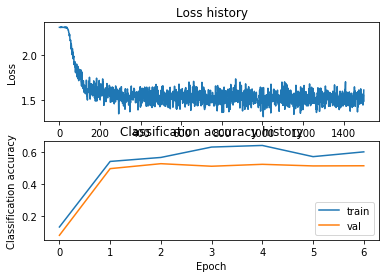

0.513
0.6
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.786723
iteration 200 / 1500: loss 1.609854
iteration 300 / 1500: loss 1.556634
iteration 400 / 1500: loss 1.550333
iteration 500 / 1500: loss 1.522573
iteration 600 / 1500: loss 1.574329
iteration 700 / 1500: loss 1.551539
iteration 800 / 1500: loss 1.604511
iteration 900 / 1500: loss 1.505645
iteration 1000 / 1500: loss 1.606425
iteration 1100 / 1500: loss 1.481618
iteration 1200 / 1500: loss 1.492961
iteration 1300 / 1500: loss 1.478164
iteration 1400 / 1500: loss 1.606718


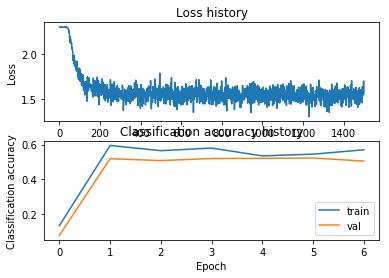

0.505
0.57
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.750552
iteration 200 / 1500: loss 1.525788
iteration 300 / 1500: loss 1.604884
iteration 400 / 1500: loss 1.534468
iteration 500 / 1500: loss 1.567507
iteration 600 / 1500: loss 1.505470
iteration 700 / 1500: loss 1.564507
iteration 800 / 1500: loss 1.467280
iteration 900 / 1500: loss 1.618310
iteration 1000 / 1500: loss 1.525612
iteration 1100 / 1500: loss 1.589553
iteration 1200 / 1500: loss 1.513201
iteration 1300 / 1500: loss 1.465024
iteration 1400 / 1500: loss 1.496531


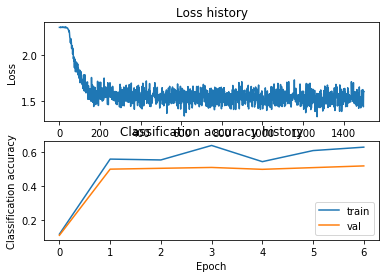

0.52
0.63
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.828985
iteration 200 / 1500: loss 1.602027
iteration 300 / 1500: loss 1.592860
iteration 400 / 1500: loss 1.540083
iteration 500 / 1500: loss 1.527059
iteration 600 / 1500: loss 1.559501
iteration 700 / 1500: loss 1.415099
iteration 800 / 1500: loss 1.457615
iteration 900 / 1500: loss 1.528072
iteration 1000 / 1500: loss 1.409170
iteration 1100 / 1500: loss 1.561984
iteration 1200 / 1500: loss 1.583333
iteration 1300 / 1500: loss 1.435647
iteration 1400 / 1500: loss 1.441333


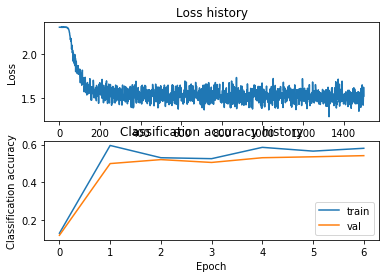

0.541
0.58
iteration 0 / 1500: loss 2.302591
iteration 100 / 1500: loss 1.669080
iteration 200 / 1500: loss 1.565319
iteration 300 / 1500: loss 1.493530
iteration 400 / 1500: loss 1.486625
iteration 500 / 1500: loss 1.529428
iteration 600 / 1500: loss 1.476510
iteration 700 / 1500: loss 1.426741
iteration 800 / 1500: loss 1.450922
iteration 900 / 1500: loss 1.480063
iteration 1000 / 1500: loss 1.610953
iteration 1100 / 1500: loss 1.486688
iteration 1200 / 1500: loss 1.511123
iteration 1300 / 1500: loss 1.499771
iteration 1400 / 1500: loss 1.459271


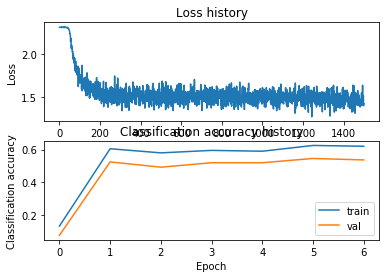

0.537
0.62
iteration 0 / 1500: loss 2.302593
iteration 100 / 1500: loss 1.742101
iteration 200 / 1500: loss 1.571714
iteration 300 / 1500: loss 1.459352
iteration 400 / 1500: loss 1.585652
iteration 500 / 1500: loss 1.519910
iteration 600 / 1500: loss 1.629841
iteration 700 / 1500: loss 1.638073
iteration 800 / 1500: loss 1.618089
iteration 900 / 1500: loss 1.547141
iteration 1000 / 1500: loss 1.518047
iteration 1100 / 1500: loss 1.563130
iteration 1200 / 1500: loss 1.485669
iteration 1300 / 1500: loss 1.574820
iteration 1400 / 1500: loss 1.441717


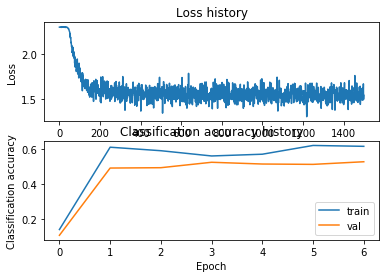

0.527
0.615
iteration 0 / 1500: loss 2.302590
iteration 100 / 1500: loss 1.811957
iteration 200 / 1500: loss 1.511440
iteration 300 / 1500: loss 1.409696
iteration 400 / 1500: loss 1.489167
iteration 500 / 1500: loss 1.660989
iteration 600 / 1500: loss 1.459214
iteration 700 / 1500: loss 1.441426
iteration 800 / 1500: loss 1.394687
iteration 900 / 1500: loss 1.468957
iteration 1000 / 1500: loss 1.520132
iteration 1100 / 1500: loss 1.444417
iteration 1200 / 1500: loss 1.393284
iteration 1300 / 1500: loss 1.475127
iteration 1400 / 1500: loss 1.587448


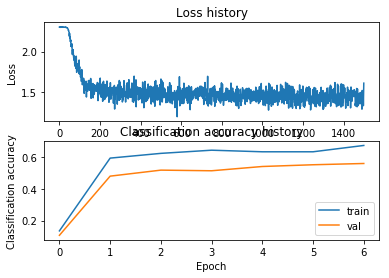

0.561
0.675
iteration 0 / 1500: loss 2.302589
iteration 100 / 1500: loss 1.740191
iteration 200 / 1500: loss 1.606776
iteration 300 / 1500: loss 1.505355
iteration 400 / 1500: loss 1.491760
iteration 500 / 1500: loss 1.408607
iteration 600 / 1500: loss 1.471426
iteration 700 / 1500: loss 1.523156
iteration 800 / 1500: loss 1.358506
iteration 900 / 1500: loss 1.414114
iteration 1000 / 1500: loss 1.543277
iteration 1100 / 1500: loss 1.419895
iteration 1200 / 1500: loss 1.407541
iteration 1300 / 1500: loss 1.441049
iteration 1400 / 1500: loss 1.417455


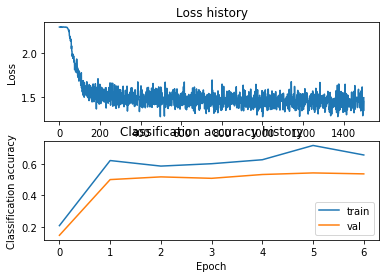

0.536
0.655
iteration 0 / 1500: loss 2.302592
iteration 100 / 1500: loss 1.785337
iteration 200 / 1500: loss 1.629911
iteration 300 / 1500: loss 1.611317
iteration 400 / 1500: loss 1.623916
iteration 500 / 1500: loss 1.554824
iteration 600 / 1500: loss 1.588176
iteration 700 / 1500: loss 1.501729
iteration 800 / 1500: loss 1.552951
iteration 900 / 1500: loss 1.371526
iteration 1000 / 1500: loss 1.407336
iteration 1100 / 1500: loss 1.541718
iteration 1200 / 1500: loss 1.549463
iteration 1300 / 1500: loss 1.528192
iteration 1400 / 1500: loss 1.556716


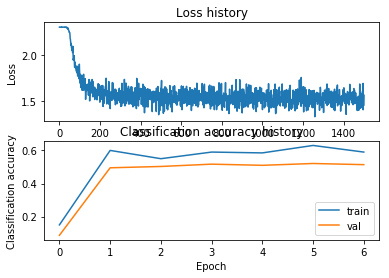

0.514
0.59
lr 1.240447e-01 reg 5.255449e-03 train accuracy: 0.575000 val accuracy: 0.510000
lr 1.240447e-01 reg 5.304086e-03 train accuracy: 0.610000 val accuracy: 0.519000
lr 1.240447e-01 reg 6.654521e-03 train accuracy: 0.530000 val accuracy: 0.527000
lr 1.240447e-01 reg 7.736505e-03 train accuracy: 0.550000 val accuracy: 0.518000
lr 1.240447e-01 reg 7.860434e-03 train accuracy: 0.580000 val accuracy: 0.520000
lr 1.240447e-01 reg 8.203834e-03 train accuracy: 0.510000 val accuracy: 0.517000
lr 1.240447e-01 reg 8.480455e-03 train accuracy: 0.495000 val accuracy: 0.522000
lr 1.240447e-01 reg 8.597214e-03 train accuracy: 0.540000 val accuracy: 0.523000
lr 1.240447e-01 reg 9.291738e-03 train accuracy: 0.560000 val accuracy: 0.517000
lr 1.240447e-01 reg 9.864020e-03 train accuracy: 0.520000 val accuracy: 0.506000
lr 2.379607e-01 reg 5.255449e-03 train accuracy: 0.600000 val accuracy: 0.523000
lr 2.379607e-01 reg 5.304086e-03 train accuracy: 0.580000 val accuracy: 0.539000
lr 2.379607e-01 r

In [17]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
results = {}
best_val = -1
best_net = None
#learning_rates = [3.771682e-01]
#regularization_strengths = [5.526481e-03]
learning_rates = np.random.uniform(low = 1e-1, high = 4e-1, size = (10, ))
regularization_strengths = np.random.uniform(low = 0.005, high = 0.01, size = (10, ))

for i in range(len(learning_rates)):
    for j in range(len(regularization_strengths)):
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        twolayernet = TwoLayerNet(input_dim, hidden_dim, num_classes)
        dic  = twolayernet.train(X_train_feats, y_train, X_val_feats, y_val, learning_rates[i],0.95,  regularization_strengths[j], 1500, 200, True)
        loss_history, train_acc_history, val_acc_history = dic['loss_history'], dic['train_acc_history'], dic['val_acc_history']
        plt.subplot(2, 1, 1)
        plt.plot(loss_history)
        plt.title('Loss history')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')

        plt.subplot(2, 1, 2)
        plt.plot(train_acc_history, label='train')
        plt.plot(val_acc_history, label='val')
        plt.title('Classification accuracy history')
        plt.xlabel('Epoch')
        plt.ylabel('Classification accuracy')
        plt.legend()
        plt.show()
        val_acc = val_acc_history[len(val_acc_history) - 1]
        train_acc = train_acc_history[len(train_acc_history) - 1]
        print(val_acc)
        print(train_acc)
        results[(learning_rates[i], regularization_strengths[j])] = (train_acc, val_acc)
        if(val_acc > best_val):
            best_val = val_acc
            best_net = twolayernet
pass
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


In [18]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.514
